In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

<b><center><font size="20">Subgrid parameterization of eddy, meanfield and topographic interactions in simulations of an idealized Antarctic Circumpolar Current</font></center></b>

<center><font size="10">Vassili Kitsios, Jorgen S. Frederiksen & Terence J. O'Kane</font></center>

In [2]:
%matplotlib inline

In [3]:
# Loading libaries
import datetime
import os

import numpy as np
import sys
import os
import copy
import string
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

import xarray as xr
import spharm

import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from ssp import *
from ssp_vis import *

In [4]:
# plot settings
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 24
plt.rcParams['font.family'] = "latex"
matplotlib.rcParams['xtick.major.pad']=12
matplotlib.rcParams['ytick.major.pad']=12
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
data_dir = '../data' # set to location of the data

#read_meanfields=True # set to True if the meanfield samples have been downloaded.
read_meanfields=False # set to False if the meanfield samples have not been downloaded.

write_output=False # set to False as to not write over the pre-calculated results provided in this repo.

# Code

In [6]:
def read_matrix_aniso(inputfilename):
    raw_data = read_ascii_2d(inputfilename)
    n = raw_data[0,:,0]
    m = raw_data[1,0,:]
    Tr_n = len(n)
    Tr_m = len(m)    
    num_var = int( (len(raw_data[:,0,0])-1)/2/2 )
    coef = np.array(np.zeros((num_var,num_var,Tr_n,Tr_m), dtype=np.complex64))
    for i in range(0,num_var):
        for j in range(0,num_var):        
            pos = (i*num_var+j)*2 + 2
            coef[i,j,:,:].real = raw_data[pos,:,:]
            coef[i,j,:,:].imag = raw_data[pos+1,:,:]        
    return coef, n, m

In [7]:
def read_ascii_2d(inputfilename):
    f = open(inputfilename, 'r')
    N=0
    line_list = [0]
    while len(line_list)>0:
        line_list = f.readline().strip().split()
        if len(line_list)>0:
            if line_list[0] != '#':
                N=N+1
                Ncol = len(line_list)
    f.close()

    f = open(inputfilename, 'r')
    raw_data = np.array(np.zeros((Ncol, N, N), dtype=np.float64))
    j=0
    for line in f:
        line_list = line.strip().split()
        if len(line_list)>0:        
            if line_list[0] != '#':
                j = int(line_list[0])
                k = int(line_list[1])
                for i in range(0,Ncol):
                    raw_data[i,j,k] = float(line_list[i])
    f.close()
    return raw_data

In [8]:
def read_topography(inputfilename):
    raw_data = read_ascii_2d(inputfilename)
    n = raw_data[0,:,0]
    m = raw_data[1,0,:]
    Tr_n = len(n)
    Tr_m = len(m)    
    num_lev = 2
    coef = np.array(np.zeros((Tr_n,Tr_m), dtype=np.complex64))
    coef[:,:].real = raw_data[2,:,:]
    coef[:,:].imag = raw_data[3,:,:]
    return coef, n, m

In [9]:
def read_field_aniso(inputfilename_prefix):
    raw_data_L1 = read_ascii_2d(inputfilename_prefix + '.L01.dat')
    raw_data_L2 = read_ascii_2d(inputfilename_prefix + '.L02.dat')    
    n = raw_data_L1[0,:,0]
    m = raw_data_L1[1,0,:]
    Tr_n = len(n)
    Tr_m = len(m)    
    num_lev = 2
    coef = np.array(np.zeros((num_lev,Tr_n,Tr_m), dtype=np.complex64))
    coef[0,:,:].real = raw_data_L1[2,:,:]
    coef[0,:,:].imag = raw_data_L1[3,:,:]
    coef[1,:,:].real = raw_data_L2[2,:,:]
    coef[1,:,:].imag = raw_data_L2[3,:,:]    
    return coef, n, m

In [10]:
def read_spectral_components(simulation_dir, timestep=7000):
    a     = 6.371e6   # radius of the Earth (m)
    
    Etot, n = read_spectra(simulation_dir+'/results/spectra/spectra.energy_k.n.'+'{:06d}'.format(timestep))
    vort_avg = read_field_aniso(simulation_dir+'/results/fields/vort.avg')[0]
    Eavg = isotropise_field(np.real(vort_avg*vort_avg.conj())/8.0, calc_avg=False)[:,1:]/n/(n+1.0)*a*a
    Eprime = Etot - Eavg
    
    vort_topo = read_topography(simulation_dir+'/results/initial_conditions/topography.scaled.dat')[0]
    Etopo_avg = copy.deepcopy(Eavg)
    Etopo_avg[0,:] = np.real(isotropise_topography(np.abs(vort_avg[0,:,:]*vort_topo.conj()), calc_avg=False))[1:]/n/(n+1.0)*a*a
    Etopo_avg[1,:] = np.real(isotropise_topography(np.abs(vort_avg[1,:,:]*vort_topo.conj()), calc_avg=False))[1:]/n/(n+1.0)*a*a
    
    Etopo = np.real(isotropise_topography(np.abs(vort_topo*vort_topo.conj()), calc_avg=False))[1:]/n/(n+1.0)*a*a

    vort_nudge = read_field_aniso(simulation_dir + '/results/target_conditions/vort.target_climate')[0]
    Enudge = isotropise_field(np.real(vort_nudge*vort_nudge.conj())/8.0, calc_avg=False)[:,1:]/n/(n+1.0)*a*a;
    
    results = dict()
    results['Etot'] = Etot
    results['Eavg'] = Eavg
    results['Eprime'] = Eprime
    results['Etopo_avg'] = Etopo_avg
    results['Etopo'] = Etopo
    results['Enudge'] = Enudge
    results['n'] = n
    
    return results

In [11]:
def read_spectra(inputfilename_prefix, trunc=False, read_min_max=False):
    if trunc:
        raw_data_L1 = read_ascii_1d(inputfilename_prefix + '.L01.trunc.dat')
        raw_data_L2 = read_ascii_1d(inputfilename_prefix + '.L02.trunc.dat')    
    else:
        raw_data_L1 = read_ascii_1d(inputfilename_prefix + '.L01.dat')
        raw_data_L2 = read_ascii_1d(inputfilename_prefix + '.L02.dat')

    k = raw_data_L1[0,:]
    num_lev = 2
    Tr = len(k)    
    coef = np.array(np.zeros((num_lev,Tr), dtype=np.float64))
    coef[0,:] = raw_data_L1[3,:]
    coef[0,:] = raw_data_L1[3,:]    
    coef[1,:] = raw_data_L2[3,:]
    coef[1,:] = raw_data_L2[3,:]    
    
    if read_min_max:
        coef_min = np.array(np.zeros((num_lev,Tr), dtype=np.float64))
        coef_min[0,:] = raw_data_L1[2,:]
        coef_min[0,:] = raw_data_L1[2,:]    
        coef_min[1,:] = raw_data_L2[2,:]
        coef_min[1,:] = raw_data_L2[2,:]    

        coef_max = np.array(np.zeros((num_lev,Tr), dtype=np.float64))
        coef_max[0,:] = raw_data_L1[4,:]
        coef_max[0,:] = raw_data_L1[4,:]    
        coef_max[1,:] = raw_data_L2[4,:]
        coef_max[1,:] = raw_data_L2[4,:]    

        return coef, k, coef_min, coef_max
    else:
        return coef, k

In [12]:
def read_ascii_1d(inputfilename):
    f = open(inputfilename, 'r')
    N=0
    for line in f:
        line_list = line.strip().split()
        if line_list[0] != '#':
            N=N+1
    f.close()
    Ncol = len(line_list)

    f = open(inputfilename, 'r')
    raw_data = np.array(np.zeros((Ncol,N), dtype=np.float64))
    j=0
    for line in f:
        line_list = line.strip().split()
        if line_list[0] != '#':
            for i in range(0,Ncol):
                raw_data[i,j] = float(line_list[i])
            j=j+1
    f.close()
    return raw_data    

In [13]:
def write_ascii_anisotropic_matrix(filename,data):
    nlev,nlev,T,T = np.shape(data)    
    file = open(filename,'w')
    for i in range(0,T):
        for k in range(0,T):
            file.write('%4.1d %4.1d %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e\n' % (i, k, data.real[0,0,i,k], data.imag[0,0,i,k], data.real[0,1,i,k], data.imag[0,1,i,k], data.real[1,0,i,k], data.imag[1,0,i,k], data.real[1,1,i,k], data.imag[1,1,i,k]))
        file.write('\n')
    file.close()

In [14]:
def write_ascii_isotropic_matrix(filename,data):
    nlev,nlev,T = np.shape(data)    
    file = open(filename,'w')
    for i in range(0,T):
        file.write('%4.1d %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e %21.12e\n' % (i, data.real[0,0,i], data.imag[0,0,i], data.real[0,1,i], data.imag[0,1,i], data.real[1,0,i], data.imag[1,0,i], data.real[1,1,i], data.imag[1,1,i] ))
    file.close()

In [15]:
def write_ascii_anisotropic_vector(filename,data):
    nlev,T,T = np.shape(data)    
    file = open(filename,'w')
    for i in range(0,T):
        for k in range(0,T):
            file.write('%4.1d %4.1d %21.12e %21.12e %21.12e %21.12e\n' % (i, k, data.real[0,i,k], data.imag[0,i,k], data.real[1,i,k], data.imag[1,i,k]))
        file.write('\n')
    file.close()

In [16]:
def write_ascii_isotropic_vector(filename,data):
    nlev,T = np.shape(data)    
    file = open(filename,'w')
    for i in range(0,T):
        file.write('%4.1d %21.12e %21.12e %21.12e %21.12e\n' % (i, data.real[0,i], data.imag[0,i], data.real[1,i], data.imag[1,i]))
    file.close()

In [17]:
def write_ascii_field_2d(filename,data):
    nlev,T = np.shape(data)    
    file = open(filename,'w')
    for i in range(0,T):
        for k in range(0,T):
            file.write('%4.1d %4.1d %21.12e %21.12e\n' % (i, k, data.real[i,k], data.imag[i,k]))
        file.write('\n')
    file.close()
    return

In [18]:
def isotropise_topography(field, calc_mag_first=False, calc_avg=True):
    T,T = np.shape(field)
    if calc_mag_first:
        field_iso = np.array(np.zeros((T), dtype=np.float64))
    else:
        field_iso = np.array(np.zeros((T), dtype=np.complex64))
    for j in range(0,T):
        for i in range(0,j+1):
            sym_count=2.0
            if (i==0):
                sym_count=1.0
            if calc_mag_first:
                field_iso[j] += np.real( np.conj( field[i,j] ) * field[i,j] ) * sym_count
            else:
                field_iso[j] += field[i,j] * sym_count
        if calc_avg:
            field_iso[j] /= float(2.0*j+1.0)
    if calc_mag_first:
        return np.sqrt(field_iso)
    else:
        return field_iso

In [19]:
def isotropise_field(field, calc_mag_first=False, calc_avg=True):
    nlev,T,T = np.shape(field)
    if calc_mag_first:
        field_iso = np.array(np.zeros((nlev,T), dtype=np.float64))
    else:
        field_iso = np.array(np.zeros((nlev,T), dtype=np.complex64))
    for j in range(0,T):
        for i in range(0,j+1):
            sym_count=2.0
            if (i==0):
                sym_count=1.0
            if calc_mag_first:
                field_iso[:,j] += np.real( np.conj( field[:,i,j] ) * field[:,i,j] ) * sym_count
            else:
                field_iso[:,j] += field[:,i,j] * sym_count
        if calc_avg:
            field_iso[:,j] /= float(2.0*j+1.0)
    if calc_mag_first:
        return np.sqrt(field_iso)
    else:
        return field_iso

In [20]:
def isotropise_field_samples(field, calc_mag_first=False, calc_avg=True):
    nlev,T,T,num_samples = np.shape(field)
    if calc_mag_first:
        field_iso = np.array(np.zeros((nlev,T), dtype=np.float64))
    else:
        field_iso = np.array(np.zeros((nlev,T), dtype=np.complex64))
    for j in range(0,T):
        for i in range(0,j+1):
            sym_count=2.0
            if (i==0):
                sym_count=1.0
            if calc_mag_first:
                field_iso[:,j] += np.mean(np.real(np.abs(field[:,i,j,:]) * np.abs(field[:,i,j,:])),axis=1) * sym_count
            else:
                field_iso[:,j] += np.mean(field[:,i,j,:],axis=1) * sym_count
        if calc_avg:
            field_iso[:,j] /= float(2.0*j+1.0)
    if calc_mag_first:
        return np.sqrt(field_iso)
    else:
        return field_iso

In [21]:
def isotropise_matrix(matrix):
    nlev,nlev,T,T = np.shape(matrix)
    matrix_iso = np.array(np.zeros((nlev,nlev,T), dtype=np.complex64))
    for j in range(0,T):
        for i in range(0,j+1):
            sym_count=2.0
            if (i==0):
                sym_count=1.0
            matrix_iso[:,:,j] += matrix[:,:,i,j] * sym_count
        matrix_iso[:,:,j] /= float(2.0*j+1.0)
    return matrix_iso

In [22]:
def convert_q_to_vort(FL,q_field):
    nlev,T,T = np.shape(q_field)
    vort_field = np.array(np.zeros((nlev,T,T), dtype=np.complex64))
    for j in range(0,T):
        for i in range(0,j+1):
            if j==0:
                denom = 1.0 + FL/2.0
            else:
                denom = 1.0 + FL/float(j)/(float(j)+1.0)
            BT = (q_field[0,i,j] + q_field[1,i,j])/2.0
            BC = (q_field[0,i,j] - q_field[1,i,j])/2.0/denom
            vort_field[0,i,j] =  BT + BC
            vort_field[1,i,j] =  BT - BC
    return vort_field

In [23]:
class SubgridModel(object):

    #---------------------------------------------------------------------------
    def __init__(self, FL=4e4):
        self.omega   = 7.292e-5  # omega - rotational speed of Earth [1/s]
        self.FL      = FL     # layer coupling parameter
        self.read_meanfields = True     # flag to read mean climate sates
        return
    
    #---------------------------------------------------------------------------    
    def read_data(self, input_data_dir, spin_up=0, read_meanfields=True, num_meanfields=None, combined_dir='dns_combined'):
        self.input_data_dir = input_data_dir
        
        dns_dir_list = glob.glob(self.input_data_dir + '/dns??.????')
        
        topography_filename = dns_dir_list[0] + '/results/initial_conditions/topography.scaled.dat'
        if os.path.isfile(topography_filename):
            self.h = read_topography(topography_filename)[0] # units of metres
        else:
            self.h = None
            
        self.tauM = int(self.input_data_dir[-8:-4])
        print('Number of timesteps to calculate of each climate state = {0}'.format(self.tauM))

        print('Reading eddy-eddy model')        
        self.czero, self.n, self.m       =  read_matrix_aniso(input_data_dir + '/'+combined_dir+'/results/subgrid/czero_aniso.dat')     
        self.tzero =  read_matrix_aniso(input_data_dir + '/'+combined_dir+'/results/subgrid/tzero_aniso.dat')[0]
        self.cint  =  read_matrix_aniso(input_data_dir + '/'+combined_dir+'/results/subgrid/cint_aniso.dat')[0]
        self.tint  =  read_matrix_aniso(input_data_dir + '/'+combined_dir+'/results/subgrid/tint_aniso.dat')[0]
        
        self.Tr_n    = len(self.n)
        self.Tr_m    = len(self.m)
        self.num_lev = len(self.czero[:,0,0,0])
                
        print('Reading mean subgrid tendencies')
        self.f_subgrid_avg = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m), dtype=np.complex64))
        self.f_subgrid_avg = read_field_aniso(input_data_dir + '/'+combined_dir+'/results/subgrid/red_vort_subgrid_tend.avg_trunc')[0]/self.omega/self.omega
        self.f_subgrid_avg_iso = isotropise_field(self.f_subgrid_avg)
        self.f_subgrid_avg_mag_iso = isotropise_field(self.f_subgrid_avg, calc_mag_first=True)
                    
        self.read_meanfields = read_meanfields
        if self.read_meanfields:
            print('Reading climate states and tendencies')        
            self.dir_list = sorted(glob.glob(self.input_data_dir + '/dns??.????.meanfield_jacobian/*'))
            if num_meanfields is not None:
                self.dir_list = self.dir_list[0:num_meanfields]
                
            if len(self.dir_list)>spin_up:
                self.dir_list = self.dir_list[spin_up:]
            else:
                print('ERROR : spinup longer than record length.')
                sys.exit()
            self.num_samples = len(self.dir_list)
            print('   number of files = {0}'.format(self.num_samples))

            this_dir = self.dir_list[0]
            batch_name = this_dir[-36:-26]
            climate_name = this_dir[-6:]

            self.f = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m,self.num_samples), dtype=np.complex64))
            self.q = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m,self.num_samples), dtype=np.complex64))
            self.b = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m,self.num_samples), dtype=np.complex64))
            for i in range(0,self.num_samples):
                print('    sample {0} of {1}'.format(i+1,self.num_samples))
                this_dir = self.dir_list[i]
                batch_name = this_dir[-36:-26]
                climate_name = this_dir[-6:]
                f_filename = self.dir_list[i] + '/results/OLS/red_vort_subgrid_tend.avg_trunc.all_steps'
                q_filename = self.dir_list[i] + '/results/OLS/red_vort.avg_trunc.all_steps'
                b_filename = self.dir_list[i] + '/results/OLS/red_vort_subgrid_tend.avg_trunc'                
                self.f[:,:,:,i] = read_field_aniso(f_filename)[0]
                self.q[:,:,:,i] = read_field_aniso(q_filename)[0]
                self.b[:,:,:,i] = read_field_aniso(b_filename)[0]
            self.q = self.q/self.omega
            self.f = self.f/self.omega/self.omega
            self.b = self.b/self.omega/self.omega
            self.h = self.h/self.omega

            print('Calculating sample averages')
            self.f_avg = np.mean(self.f,axis=3)
            self.q_avg = np.mean(self.q,axis=3)
            self.b_avg = np.nanmean(self.b,axis=3)
            
            print('Isotropising fields and matrices')
            self.f_avg_iso       = isotropise_field(self.f_avg)
            self.q_avg_iso       = isotropise_field(self.q_avg)
            self.b_avg_iso       = isotropise_field(self.b_avg)
            self.f_avg_mag_iso   = isotropise_field(self.f_avg,  calc_mag_first=True)
            self.q_avg_mag_iso   = isotropise_field(self.q_avg,  calc_mag_first=True)
            self.b_avg_mag_iso   = isotropise_field(self.b_avg,  calc_mag_first=True)
            self.f_mag_iso   = isotropise_field_samples(self.f,  calc_mag_first=True)
            self.q_mag_iso   = isotropise_field_samples(self.q,  calc_mag_first=True)
            self.b_mag_iso   = isotropise_field_samples(self.b,  calc_mag_first=True)
        return
    
    #---------------------------------------------------------------------------    
    def calculate_eddy_coefficients(self, FL=4e4): 
        
        self.FL = FL
        
        print('Isotropising subgrid statistics')
        self.czero_iso = isotropise_matrix(self.czero)
        self.tzero_iso = isotropise_matrix(self.tzero)
        self.cint_iso  = isotropise_matrix(self.cint)
        self.tint_iso  = isotropise_matrix(self.tint)
        
        print('Calculating dissipation matrices and eigenvalues from anisotropic subgrid statistics')
        self.net         = copy.deepcopy(self.czero)*0.0
        self.drain       = copy.deepcopy(self.czero)*0.0
        self.backscatter = copy.deepcopy(self.czero)*0.0     
        self.bnoise      = copy.deepcopy(self.czero)*0.0
        self.evalue      = copy.deepcopy(self.czero[0,:,:,:])*0.0
        self.evector     = copy.deepcopy(self.czero)*0.0
        self.net_evalue  = copy.deepcopy(self.czero[0,:,:,:])*0.0
        self.drain_evalue= copy.deepcopy(self.czero[0,:,:,:])*0.0
        self.net_baro    = copy.deepcopy(self.czero)*0.0
        self.drain_baro  = copy.deepcopy(self.czero)*0.0 
        self.net_vort    = copy.deepcopy(self.czero)*0.0
        self.drain_vort  = copy.deepcopy(self.czero)*0.0 
        for ii in range(0,self.Tr_n):
            if ii%10 == 0:
                print('   {0} of {1}'.format(ii,self.Tr_n))
            for jj in range(ii,self.Tr_m):
                self.net[:,:,ii,jj], self.drain[:,:,ii,jj], self.backscatter[:,:,ii,jj], self.bnoise[:,:,ii,jj], self.evalue[:,ii,jj], self.evector[:,:,ii,jj], self.net_evalue[:,ii,jj], self.drain_evalue[:,ii,jj] \
                    = self.calculate_dissipation(ii, self.czero[:,:,ii,jj], self.tzero[:,:,ii,jj], self.cint[:,:,ii,jj], self.tint[:,:,ii,jj]) 
                self.net_baro[:,:,ii,jj]   = self.convert_evis_q_to_baro(ii,FL,self.net[:,:,ii,jj])
                self.drain_baro[:,:,ii,jj] = self.convert_evis_q_to_baro(ii,FL,self.drain[:,:,ii,jj])
                self.net_vort[:,:,ii,jj]   = self.convert_evis_baro_to_vort(self.net_baro[:,:,ii,jj])
                self.drain_vort[:,:,ii,jj] = self.convert_evis_baro_to_vort(self.drain_baro[:,:,ii,jj])
        self.backscatter_baro = self.net_baro - self.drain_baro
        self.backscatter_vort = self.net_vort - self.drain_vort
        
        print('   minimum drain eigenvalue = ',np.min(self.drain_evalue.real))
        print('   minimum net eigenvalue = ',np.min(self.net_evalue.real))
        
        print('Calculating dissipation matrices and eigenvalues from isotropic subgrid statistics')
        self.net_iso         = copy.deepcopy(self.czero_iso)*0.0
        self.drain_iso       = copy.deepcopy(self.czero_iso)*0.0        
        self.backscatter_iso = copy.deepcopy(self.czero_iso)*0.0        
        self.bnoise_iso      = copy.deepcopy(self.czero_iso)*0.0
        self.evalue_iso      = copy.deepcopy(self.czero_iso[0,:,:])*0.0
        self.evector_iso     = copy.deepcopy(self.czero_iso)*0.0
        self.net_evalue_iso  = copy.deepcopy(self.czero_iso[0,:,:])*0.0
        self.drain_evalue_iso= copy.deepcopy(self.czero_iso[0,:,:])*0.0
        for ii in range(0,self.Tr_n):
            self.net_iso[:,:,ii], self.drain_iso[:,:,ii], self.backscatter_iso[:,:,ii], self.bnoise_iso[:,:,ii], self.evalue_iso[:,ii], self.evector_iso[:,:,ii], self.net_evalue_iso[:,ii], self.drain_evalue_iso[:,ii] \
                = self.calculate_dissipation(ii, self.czero_iso[:,:,ii], self.tzero_iso[:,:,ii], self.cint_iso[:,:,ii], self.tint_iso[:,:,ii])
            
        print('Isotropising anisotropic dissipation matrices and calculating the eigenvalues')
        self.drain_iso_post       = isotropise_matrix(self.drain)
        self.backscatter_iso_post = isotropise_matrix(self.backscatter)
        self.net_iso_post         = isotropise_matrix(self.net)
        self.drain_evalue_iso_post= isotropise_field(self.drain_evalue)
        self.net_evalue_iso_post  = isotropise_field(self.net_evalue)
        self.bnoise_iso_post      = copy.deepcopy(self.czero_iso)*0.0
        self.evalue_iso_post      = copy.deepcopy(self.czero_iso[0,:,:])*0.0
        self.evector_iso_post     = copy.deepcopy(self.czero_iso)*0.0
        for ii in range(0,self.Tr_n):
            bnoise_tmp = -np.dot(self.backscatter_iso_post[:,:,ii], self.czero_iso[:,:,ii])
            self.bnoise_iso_post[:,:,ii] = bnoise_tmp + bnoise_tmp.T.conj()
            self.evalue_iso_post[:,ii], self.evector_iso_post[:,:,ii] = linalg.eig(self.bnoise_iso_post[:,:,ii])
        self.evalue_iso_post.real[self.evalue_iso_post.real<0.0] = 0.0
        self.evalue_iso_post.imag = 0.0

        return


    #---------------------------------------------------------------------------    
    def calculate_dissipation(self, ii, this_czero, this_tzero, this_cint, this_tint, tol=1.0e-15, cond_tol=100):
        net             = -np.dot(this_tzero, linalg.pinvh(this_czero, rcond=tol))            
        drain           = -np.dot(this_tint, linalg.pinvh(this_cint, rcond=tol))
        bnoise_temp     = -np.dot(net-drain, this_czero)
        if (np.linalg.cond(net)>cond_tol) or (np.linalg.cond(drain)>cond_tol) or np.isnan( np.sum(net).real + np.sum(drain).real + np.sum(bnoise_temp).real ):
            net[:,:] = 0.0
            drain[:,:] = 0.0
            bnoise_temp[:,:] = 0.0
        back     = net - drain    
        
        bnoise   = bnoise_temp + bnoise_temp.T.conj()
        evalue, evector = linalg.eig(bnoise)
        evalue.real[evalue.real<0.0] = 0.0
        evalue[:].imag = 0.0

        ev_net   = np.sort(linalg.eig(net)[0])
        ev_drain = np.sort(linalg.eig(drain)[0])

        return net, drain, back, bnoise, evalue, evector, ev_net, ev_drain
    

    #---------------------------------------------------------------------------    
    def calculate_meanfield_coefficients(self, tol=1e-15, cond_tol=100):
        if not self.read_meanfields:
            print('Meanfields not yet read from file.')
            return
        f           = self.f
        b           = self.b
        q           = self.q
        num_samples = len(f[0,0,0,:])

        print('Calculating meanfield coefficients')
        self.T0_meanfield = np.array(np.zeros((self.num_lev,self.num_lev,self.Tr_n,self.Tr_m), dtype=np.complex64))
        self.C0_meanfield = np.array(np.zeros((self.num_lev,self.num_lev,self.Tr_n,self.Tr_m), dtype=np.complex64))
        self.D_meanfield  = np.array(np.zeros((self.num_lev,self.num_lev,self.Tr_n,self.Tr_m), dtype=np.complex64))
        self.D_q          = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m,self.num_samples), dtype=np.complex64))
        A = np.array(np.zeros((self.num_lev,1), dtype=np.complex64))
        B = np.array(np.zeros((self.num_lev,1), dtype=np.complex64))                
        for ii in range(0,self.Tr_n):
            if ii%10 == 0:
                print('   {0} of {1}'.format(ii,self.Tr_n))
            for jj in range(ii,self.Tr_m):
                # Calculate covariances
                for kk in range(0,num_samples):
                    A[:,0] = f[:,ii,jj,kk] - self.f_avg[:,ii,jj] - b[:,ii,jj,kk] + self.b_avg[:,ii,jj]
                    B[:,0] = q[:,ii,jj,kk] - self.q_avg[:,ii,jj]
                    self.T0_meanfield[:,:,ii,jj] += np.matmul(A, B.conj().T)
                    self.C0_meanfield[:,:,ii,jj] += np.matmul(B, B.conj().T)                    
                # Calculate eddy-meanfield operator
                self.D_meanfield[:,:,ii,jj] = -np.dot(self.T0_meanfield[:,:,ii,jj],linalg.pinvh(self.C0_meanfield[:,:,ii,jj], rcond=tol))
                if (np.linalg.cond(self.D_meanfield[:,:,ii,jj])>cond_tol):
                    self.D_meanfield[:,:,ii,jj] = 0.0
                # Calculate eddy-meanfield force
                for kk in range(0,num_samples):
                    self.D_q[:,ii,jj,kk]    = np.matmul(self.D_meanfield[:,:,ii,jj], self.q[:,ii,jj,kk])
        self.T0_meanfield /= num_samples
        self.C0_meanfield /= num_samples
        
        # Calculate eddy-topographic terms                    
        self.D_q_avg   = np.mean(self.D_q,axis=3)
        self.chi_h_avg = self.f_avg - self.b_avg + self.D_q_avg
        self.chi_h     = self.f - self.b + self.D_q
        if self.h is not None:
            self.h_Tr         = self.h[0:self.Tr_n,0:self.Tr_m]            
            self.chi          = np.array(np.zeros((self.num_lev,self.Tr_n,self.Tr_m,self.num_samples), dtype=np.complex64))
            for ii in range(0,self.num_lev):
                for kk in range(0,num_samples):
                    self.chi[ii,:,:,kk] = self.chi_h[ii,:,:,kk] / self.h_Tr                
            self.chi[np.isnan(self.chi)] = 0.0
            self.chi_avg   = np.mean(self.chi,axis=3)            
        else:
            self.h_Tr    = None
            self.chi     = None            
            self.chi_avg = None
        
        print('Isotropising the fields and matrices')
        self.D_q_iso             = isotropise_field(self.D_q_avg)
        self.chi_h_iso           = isotropise_field(self.chi_h_avg)
        self.D_q_avg_mag_iso     = isotropise_field(self.D_q_avg,   calc_mag_first=True)        
        self.chi_h_avg_mag_iso   = isotropise_field(self.chi_h_avg, calc_mag_first=True)
        self.D_q_mag_iso         = isotropise_field_samples(self.D_q,   calc_mag_first=True)        
        self.chi_h_mag_iso       = isotropise_field_samples(self.chi_h, calc_mag_first=True)
        self.D_meanfield_iso     = isotropise_matrix(self.D_meanfield)
        if self.h is not None:
            self.chi_iso             = isotropise_field(self.chi_avg)
            self.chi_avg_mag_iso     = isotropise_field(self.chi_avg,   calc_mag_first=True)
            self.chi_mag_iso         = isotropise_field_samples(self.chi,   calc_mag_first=True)            
            self.h_iso               = isotropise_field(np.expand_dims(self.h_Tr, axis=0))
            self.h_mag_iso           = isotropise_field(np.expand_dims(self.h_Tr, axis=0),   calc_mag_first=True)     
        else:
            self.chi_iso             = None
            self.chi_avg_mag_iso     = None
            self.chi_mag_iso         = None
            self.h_iso               = None
            self.h_mag_iso           = None
                    
        return
    

    #---------------------------------------------------------------------------    
    def write_output_data(self, output_dir):
        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(output_dir+'iso_pre'):
            os.makedirs(output_dir+'iso_pre')
        if not os.path.exists(output_dir+'iso_post'):
            os.makedirs(output_dir+'iso_post')
            
        scale_by = self.omega*self.omega
        
        write_ascii_anisotropic_matrix(output_dir + 'drain_aniso.dat',self.drain)
        write_ascii_anisotropic_matrix(output_dir + 'net_aniso.dat',self.net)
        write_ascii_anisotropic_matrix(output_dir + 'backscatter_aniso.dat',self.backscatter)
        write_ascii_anisotropic_matrix(output_dir + 'bnoise_aniso.dat',self.bnoise)
        write_ascii_anisotropic_matrix(output_dir + 'evector_aniso.dat',self.evector)
        write_ascii_anisotropic_vector(output_dir + 'evalue_aniso.dat',self.evalue)
        
        write_ascii_isotropic_matrix(output_dir + 'iso_pre/drain_iso.dat',self.drain_iso)
        write_ascii_isotropic_matrix(output_dir + 'iso_pre/net_iso.dat',self.net_iso)
        write_ascii_isotropic_matrix(output_dir + 'iso_pre/backscatter_iso.dat',self.backscatter_iso)
        write_ascii_isotropic_matrix(output_dir + 'iso_pre/bnoise_iso.dat',self.bnoise_iso)
        write_ascii_isotropic_matrix(output_dir + 'iso_pre/evector_iso.dat',self.evector_iso)
        write_ascii_isotropic_vector(output_dir + 'iso_pre/evalue_iso.dat',self.evalue_iso)
        
        write_ascii_isotropic_matrix(output_dir + 'iso_post/drain_iso.dat',self.drain_iso_post)
        write_ascii_isotropic_matrix(output_dir + 'iso_post/net_iso.dat',self.net_iso_post)
        write_ascii_isotropic_matrix(output_dir + 'iso_post/backscatter_iso.dat',self.backscatter_iso_post)
        write_ascii_isotropic_matrix(output_dir + 'iso_post/bnoise_iso.dat',self.bnoise_iso_post)
        write_ascii_isotropic_matrix(output_dir + 'iso_post/evector_iso.dat',self.evector_iso_post)
        write_ascii_isotropic_vector(output_dir + 'iso_post/evalue_iso.dat',self.evalue_iso_post)
        
        write_ascii_anisotropic_matrix(output_dir + 'drain_meanfield_aniso.none.dat',self.drain*0.0)
        write_ascii_isotropic_matrix(output_dir + 'drain_meanfield_iso.none.dat',self.drain_iso*0.0)
        
        write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.none.L01.dat',self.f_subgrid_avg[0,:,:]*0.0)
        write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.none.L02.dat',self.f_subgrid_avg[1,:,:]*0.0)

        write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.all.L01.dat',self.f_subgrid_avg[0,:,:]*scale_by)
        write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.all.L02.dat',self.f_subgrid_avg[1,:,:]*scale_by)

        
        if self.read_meanfields:
            write_ascii_anisotropic_matrix(output_dir + 'drain_meanfield_aniso.dat',self.D_meanfield)
            write_ascii_isotropic_matrix(output_dir + 'drain_meanfield_iso.dat',self.D_meanfield_iso)

            self.vort_q_aniso_avg = convert_q_to_vort(self.FL, self.q_avg)
            write_ascii_field_2d(output_dir + 'vort.q.L01.dat',self.vort_q_aniso_avg[0,:,:]*self.omega)
            write_ascii_field_2d(output_dir + 'vort.q.L02.dat',self.vort_q_aniso_avg[1,:,:]*self.omega)      

            self.vort_f_aniso_avg = convert_q_to_vort(self.FL, self.f_avg)
            write_ascii_field_2d(output_dir + 'vort.f.L01.dat',self.vort_f_aniso_avg[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'vort.f.L02.dat',self.vort_f_aniso_avg[1,:,:]*scale_by)

            self.vort_b_aniso_avg = convert_q_to_vort(self.FL, self.b_avg)
            write_ascii_field_2d(output_dir + 'vort.b.L01.dat',self.vort_b_aniso_avg[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'vort.b.L02.dat',self.vort_b_aniso_avg[1,:,:]*scale_by)

            self.vort_D_q = convert_q_to_vort(self.FL, self.D_q_avg)
            write_ascii_field_2d(output_dir + 'vort.neg_Dq.L01.dat',-self.vort_D_q[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'vort.neg_Dq.L02.dat',-self.vort_D_q[1,:,:]*scale_by)

            self.vort_chi_h = convert_q_to_vort(self.FL, self.chi_h_avg)
            write_ascii_field_2d(output_dir + 'vort.chiH.L01.dat',self.vort_chi_h[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'vort.chiH.L02.dat',self.vort_chi_h[1,:,:]*scale_by)

            self.vort_chi = convert_q_to_vort(self.FL, self.chi_avg)
            write_ascii_field_2d(output_dir + 'vort.chi.L01.dat',self.vort_chi[0,:,:]*self.omega)
            write_ascii_field_2d(output_dir + 'vort.chi.L02.dat',self.vort_chi[1,:,:]*self.omega)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b.L01.dat',self.b_avg[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b.L02.dat',self.b_avg[1,:,:]*scale_by)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.negDq.L01.dat',-self.D_q_avg[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.negDq.L02.dat',-self.D_q_avg[1,:,:]*scale_by)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.chiH.L01.dat',self.chi_h_avg[0,:,:]*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.chiH.L02.dat',self.chi_h_avg[1,:,:]*scale_by)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.negDq_chiH.L01.dat',(self.chi_h_avg[0,:,:]-self.D_q_avg[0,:,:])*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.negDq_chiH.L02.dat',(self.chi_h_avg[1,:,:]-self.D_q_avg[1,:,:])*scale_by)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b_chiH.L01.dat',(self.b_avg[0,:,:]+self.chi_h_avg[0,:,:])*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b_chiH.L02.dat',(self.b_avg[1,:,:]+self.chi_h_avg[1,:,:])*scale_by)

            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b_negDq.L01.dat',(self.b_avg[0,:,:]-self.D_q_avg[0,:,:])*scale_by)
            write_ascii_field_2d(output_dir + 'red_vort_subgrid_tend.avg_trunc.b_negDq.L02.dat',(self.b_avg[1,:,:]-self.D_q_avg[1,:,:])*scale_by)

        else:
            print('Meanfields not yet read from file.')
        

        return

    #---------------------------------------------------------------------------    
    def convert_vector_vort_to_q(self, i,F,data_baro):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5 + c
        M[0,1] = 0.5 - c
        M[1,0] = 0.5 - c
        M[1,1] = 0.5 + c
        data = np.array(np.zeros((2), dtype=np.complex))
        data = np.dot(M,data_baro)
        return data
    
    #---------------------------------------------------------------------------    
    def convert_vector_baro_to_q(self, i,F,data_baro):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 1.0
        M[0,1] = 0.5/c
        M[1,0] = 1.0
        M[1,1] = -0.5/c
        data = np.array(np.zeros((2), dtype=np.complex))
        data = np.dot(M,data_baro)
        return data

    #---------------------------------------------------------------------------    
    def convert_vector_q_to_baro(self, i,F,data):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        data_baro = np.array(np.zeros((2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5
        M[0,1] = 0.5
        M[1,0] = c
        M[1,1] = -c
        data_baro = np.dot(M,data)
        return data_baro

    #---------------------------------------------------------------------------    
    def convert_evis_q_to_baro(self, i,F,data):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        data_baro = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5
        M[0,1] = 0.5
        M[1,0] = c
        M[1,1] = -c
        data_baro = np.dot(M,np.dot(data,linalg.inv(M)))
        return data_baro

    #---------------------------------------------------------------------------    
    def convert_evis_vort_to_q(self, i,F,data_vort):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        data_baro = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5 + c
        M[0,1] = 0.5 - c
        M[1,0] = 0.5 - c
        M[1,1] = 0.5 + c
        data = np.dot(linalg.inv(M),np.dot(data_vort,M))
        return data

    #---------------------------------------------------------------------------    
    def convert_evis_baro_to_q(self, i,F,data_baro):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        data = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5
        M[0,1] = 0.5
        M[1,0] = c
        M[1,1] = -c
        data = np.dot(linalg.inv(M),np.dot(data_baro,M))
        return data

    #---------------------------------------------------------------------------    
    def convert_stats_q_to_baro(self, i,F,data):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 0.5
        M[0,1] = 0.5
        M[1,0] = c
        M[1,1] = -c
        data_baro = np.array(np.zeros((2,2), dtype=np.complex))
        data_baro = np.dot(M,np.dot(data,M.conj().T))
        return data_baro

    #---------------------------------------------------------------------------    
    def convert_stats_baro_to_q(self, i,F,data_baro):
        M = np.array(np.zeros((2,2), dtype=np.complex))
        if (i==0):
            c = 1.0/(2.0+4.0*F/(float(i)+1.0)/(float(i)+2.0))
        else:
            c = 1.0/(2.0+4.0*F/float(i)/(float(i)+1.0))
        M[0,0] = 1.0
        M[0,1] = 0.5/c
        M[1,0] = 1.0
        M[1,1] = -0.5/c
        data = np.array(np.zeros((2,2), dtype=np.complex))
        data = np.dot(M,np.dot(data_baro,M.conj().T))
        return data

    #---------------------------------------------------------------------------    
    def convert_vector_vort_to_baro(self, data_vort):
        M = np.array(np.ones((2,2), dtype=np.complex))
        M[1,1] = -1.0
        M = M*0.5
        data_baro = np.array(np.zeros((2), dtype=np.complex))
        data_baro = np.dot(M,data_vort)
        return data_baro

    #---------------------------------------------------------------------------    
    def convert_vector_baro_to_vort(self, data_baro):
        M = np.array(np.ones((2,2), dtype=np.complex))
        M[1,1] = -1.0
        M = M*0.5
        data_vort = np.array(np.zeros((2), dtype=np.complex))
        data_vort = np.dot(2.0*M,data_baro)
        return data_vort

    #---------------------------------------------------------------------------    
    def convert_stats_baro_to_vort(self, data_baro):
        M = np.array(np.ones((2,2), dtype=np.complex))
        M[1,1] = -1.0
        M = M*0.5
        data_vort = np.array(np.zeros((2,2), dtype=np.complex))
        data_vort = np.dot(2.0*M,np.dot(data_baro,2.0*M))
        return data_vort

    #---------------------------------------------------------------------------    
    def convert_evis_baro_to_vort(self, data_baro):
        M = np.array(np.ones((2,2), dtype=np.complex))
        M[1,1] = -1.0
        M = M*0.5
        data_vort = np.array(np.zeros((2,2), dtype=np.complex))
        data_vort = np.dot(2.0*M,np.dot(data_baro,M))
        return data_vort

In [24]:
def calculate_grid(T_R):
    import spharm    
    nlat=int((T_R+1)/2*3)
    lat = spharm.gaussian_lats_wts(nlat)[0]
    lon = np.linspace(0,360,2*len(lat)+1)[0:-1]
    return lat, lon

In [25]:
def convert_spect_2d_to_1d(spect_2d, T_R):
    spect_1d = np.array(np.zeros( ( int((T_R+2)*(T_R+1)/2) ),dtype=np.complex64))
    pos=0
    for m in range(0,T_R):
        for n in range(m,T_R+1):
            spect_1d[pos]=spect_2d[m,n]
            pos+=1
    return spect_1d

In [26]:
def get_physical_fields(filename):
    T_recon=100
    vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
    vort_spectral_2d = vort_spectral_2d[:,:T_recon,:T_recon]
    n_dns = n_dns[:T_recon]
    m_dns = m_dns[:T_recon]

    T_dns = len(n_dns)-1
    lat_dns, lon_dns = calculate_grid(T_dns)
    spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')

    vort_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:T_dns+1,:T_dns+1], T_dns))
    vort_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:T_dns+1,:T_dns+1], T_dns))

    strm = copy.deepcopy(vort_spectral_2d)
    a=6.371e6
    for ii in range(1,T_dns):
        laplacian = -1.0*ii*(ii+1)/a/a
        strm[:,:,ii] = strm[:,:,ii]/laplacian

    strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
    strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
    u_L1 = -strm_L1_dy; v_L1 = strm_L1_dx

    strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
    strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
    u_L2 = -strm_L2_dy; v_L2 = strm_L2_dx
    
    output = dict()
    output['lat'] = lat_dns
    output['lon'] = lon_dns
    output['vort L1'] = vort_L1
    output['vort L2'] = vort_L2
    output['strm L1'] = strm_L1
    output['strm L2'] = strm_L2
    output['u L1'] = u_L1
    output['u L2'] = u_L2
    output['v L1'] = v_L1
    output['v L2'] = v_L2
    
    output['vort BT'] = (vort_L1+vort_L2)/2
    output['vort BC'] = vort_L1-vort_L2
    output['strm BT'] = (strm_L1+strm_L2)/2
    output['strm BC'] = strm_L1-strm_L2
    output['u BT'] = (u_L1+u_L2)/2
    output['u BC'] = u_L1-u_L2
    output['v BT'] = (v_L1+v_L2)/2
    output['v BC'] = v_L1-v_L2
    
    return output

In [27]:
def plot_field(field, lon=None, lat=None, num_contours=8, plot_lat_labels=True, plot_lon_labels=True, minC=None, maxC=None, cmap=plt.cm.bwr):

    Nlon,Nlat = np.shape(field) 
    if lon is None:
        lon = np.linspace(0,360,Nlon)
    if lat is None:
        lat = np.linspace(-90,90,Nlat)        

    field_plot = copy.deepcopy(field.T)
    print('MIN=',np.min(field_plot), ' MAX=',np.max(field_plot))
    if maxC!=None and minC!=None and minC<maxC: 
        field_plot = np.clip(field_plot,minC+np.abs(minC)*1e-2,maxC-np.abs(maxC)*1e-2)
        cb_lev = np.linspace(minC,maxC,num_contours)
        h = plt.contourf(lon,lat,field_plot,cb_lev,cmap=cmap, transform=ccrs.PlateCarree())
    else:
        minC = np.min(field_plot)
        maxC = np.max(field_plot)
        if minC<0.0 and maxC>0.0:
            maxC = max(-minC, maxC)*0.8
            minC = -maxC
            field_plot = np.clip(field_plot,minC+np.abs(minC)*1e-2,maxC-np.abs(maxC)*1e-2)
            cb_lev = np.linspace(minC,maxC,num_contours)
            h = plt.contourf(lon,lat,field_plot,cb_lev,cmap=cmap, transform=ccrs.PlateCarree())
        else:
            h = plt.contourf(lon,lat,field_plot,cmap=cmap, transform=ccrs.PlateCarree())
    
    return h

In [28]:
def add_plot_features(fig, h, ax, xticks=[0, 60, 120, 180, 240, 300, 360], yticks=[-60, -30, 0, 30, 60], orientation='horizontal', tick_rotation=0, ymin=-90, ymax=90, borders=True, coasts=True):
    plt.ylim(ymin,ymax)
    if orientation is not None:
        cb = fig.colorbar(h, orientation=orientation)
        cb.ax.tick_params(labelsize='20')
        cb.ax.set_xticklabels(cb.ax.get_xticklabels(), rotation=tick_rotation)
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if coasts:
        ax.coastlines(linewidth=2)
    if borders:
        ax.add_feature(cart.feature.BORDERS, zorder=100, edgecolor='k')
    plt.grid()

In [29]:
def zero_lower_diagonal(matrix):
    Z = copy.deepcopy(matrix)
    Tr = len(Z[0,:])
    for i in range(0,Tr):
        for j in range(i+1,Tr):
            Z[i,j] = None
    Z[0,0] = None
    return Z

In [30]:
def plot_aniso_subgrid_coef(Z, n, m, cbticks, xyticks, cbtick_fontsize=20, cmap=plt.cm.viridis, orientation='vertical', rotation=0):
    if cbticks is not None:
        epsilon = np.max(np.abs(cbticks))*1.0e-6
        plt.contourf(n, m, np.clip(Z,np.min(cbticks)+epsilon,np.max(cbticks)-epsilon), cbticks, cmap=cmap)
        if cbticks[0]*cbticks[-1]>0.0:
            cbar = plt.colorbar(ticks=cbticks, orientation=orientation)
        else:
            cbar = plt.colorbar(ticks=cbticks, orientation=orientation)
    else:
        plt.contourf(n, m, Z, cmap=cmap)
        cbar = plt.colorbar(orientation=orientation)

    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=rotation)
    cbar.ax.tick_params(labelsize=cbtick_fontsize)
    
    plt.plot(m,n,'k-')
    plt.xlabel('$m$',labelpad=-5) ; plt.ylabel('$n$')
    if xyticks is not None:
        xt=ax.set_xticks(xyticks); yt=ax.set_yticks(xyticks)
    plt.grid()

In [31]:
def plot_spectra_comparison(DNS_n_L, LES_n_L, DNS_L, NoSGS_L, AS_L, AD_L, ASNoMean_L, ADNoMean_L, DNS_L_min, DNS_L_max,\
                            xmin=1, xmax=1.2e3, ymin=1e-12, ymax=1e-4, plot_range=False, scale_label_positions_by=1):
             
    plt.plot(DNS_n_L, DNS_L, 'r--', lw=2); 
    if plot_range:
        plt.fill_between(DNS_n_L, DNS_L_min, DNS_L_max, color='r', alpha=0.2); 
    plt.plot(LES_n_L, NoSGS_L, 'k-', lw=2); 

    plt.plot(DNS_n_L, DNS_L*1e-1, 'r--', lw=2); 
    if plot_range:
        plt.fill_between(DNS_n_L, DNS_L_min*1e-1, DNS_L_max*1e-1, color='r', alpha=0.2); 
    plt.plot(LES_n_L, AS_L*1e-1, 'k-', lw=2); 

    plt.plot(DNS_n_L, DNS_L*1e-2, 'r--', lw=2); 
    if plot_range:
        plt.fill_between(DNS_n_L, DNS_L_min*1e-2, DNS_L_max*1e-2, color='r', alpha=0.2); 
    plt.plot(LES_n_L, AD_L*1e-2, 'k-', lw=2); 

    plt.plot(DNS_n_L, DNS_L*1e-3, 'r--', lw=2); 
    if plot_range:
        plt.fill_between(DNS_n_L, DNS_L_min*1e-3, DNS_L_max*1e-3, color='r', alpha=0.2); 
    plt.plot(LES_n_L, ASNoMean_L*1e-3, 'k-', lw=2); 

    plt.plot(DNS_n_L, DNS_L*1e-4, 'r--', lw=2); 
    if plot_range:
        plt.fill_between(DNS_n_L, DNS_L_min*1e-4, DNS_L_max*1e-4, color='r', alpha=0.2); 
    plt.plot(LES_n_L, ADNoMean_L*1e-4, 'k-', lw=2); 

    plt.grid()
    plt.xlabel('$n$'); plt.xlim(xmin,xmax); plt.xscale('log'); 
    plt.yscale('log'); 
    
    if ymin is not None and ymax is not None:
        ax.text(500, scale_label_positions_by*ymax/1e3, 'none', fontsize=20)
        ax.text(500, scale_label_positions_by*ymax/1e4, 'S', fontsize=20)
        ax.text(500, scale_label_positions_by*ymax/1e5, 'D', fontsize=20)
        ax.text(500, scale_label_positions_by*ymax/1e6, 'S, $\\mathbf{\\bar{f}}=0$', fontsize=20)
        ax.text(500, scale_label_positions_by*ymax/1e7, 'D, $\\mathbf{\\bar{f}}=0$', fontsize=20)
        y_arrow = 20*ymin
        plt.ylim(ymin,ymax); 
        ax.annotate('$k_R$', (288, ymin),
                xytext=(288, y_arrow), 
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=24,
                horizontalalignment='right', verticalalignment='top')

# DNS base flow and topopgraphy

In [6]:
# read topography data
topo_base_dir = data_dir+'/Tr252_tau0288_tauM8000_top'
topography_unscaled_dns_spectral_2d, n_dns, m_dns = read_topography(topo_base_dir+'/dns34.0000/results/initial_conditions/topography.unscaled.dat')
T_dns = len(n_dns)-1
T_plot = 252
lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns_topo), nlon=len(lon_dns_topo), gridtype='gaussian')
topography_unscaled_dns_physical = spharm_dns.spectogrd(convert_spect_2d_to_1d(topography_unscaled_dns_spectral_2d[:T_plot+1,:T_plot+1], T_plot))
h_physical = topography_unscaled_dns_physical - np.min(topography_unscaled_dns_physical)

a     = 6.371e6   # radius of the Earth (m)
h_dx, h_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(topography_unscaled_dns_spectral_2d[:T_plot+1,:T_plot+1], T_plot))
h_dx /= a ; h_dy /= a
h_delta_mag = np.sqrt(h_dx**2.0 + h_dy**2.0)

In [7]:
# read instantaneous data
filename = topo_base_dir+'/dns34.0000/results/fields/vort.008000'
T_recon=252
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0

T_dns = len(n_dns)-1
if T_dns>400:
    T_dns=400
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')

vort_inst_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:T_dns+1,:T_dns+1], T_dns))
vort_inst_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:T_dns+1,:T_dns+1], T_dns))

strm_inst = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm_inst[:,:,ii] = strm_inst[:,:,ii]/laplacian

strm_inst_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm_inst[0,:,:], T_dns))
strm_inst_L1_dx, strm_inst_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm_inst[0,:,:], T_dns))
u_inst_L1 = -strm_inst_L1_dy; v_inst_L1 = strm_inst_L1_dx

strm_inst_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm_inst[1,:,:], T_dns))
strm_inst_L2_dx, strm_inst_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm_inst[1,:,:], T_dns))
u_inst_L2 = -strm_inst_L2_dy; v_inst_L2 = strm_inst_L2_dx

In [8]:
# read meanfield data
filename = topo_base_dir+'/dns_combined/results/fields/vort.avg'

T_recon=252
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0

T_dns = len(n_dns)-1
if T_dns>400:
    T_dns=400
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')

vort_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:T_dns+1,:T_dns+1], T_dns))
vort_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:T_dns+1,:T_dns+1], T_dns))

strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian

strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1 = -strm_L1_dy; v_L1 = strm_L1_dx

strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2 = -strm_L2_dy; v_L2 = strm_L2_dx

MIN= 0.0  MAX= 6069.8013
MIN= 9.49688e-05  MAX= 9.100097
MIN= -0.19114614  MAX= 0.3238749
MIN= -0.12352985  MAX= 0.19540656
MIN= -0.8410516  MAX= 0.78027606
MIN= -0.5922272  MAX= 0.68899417


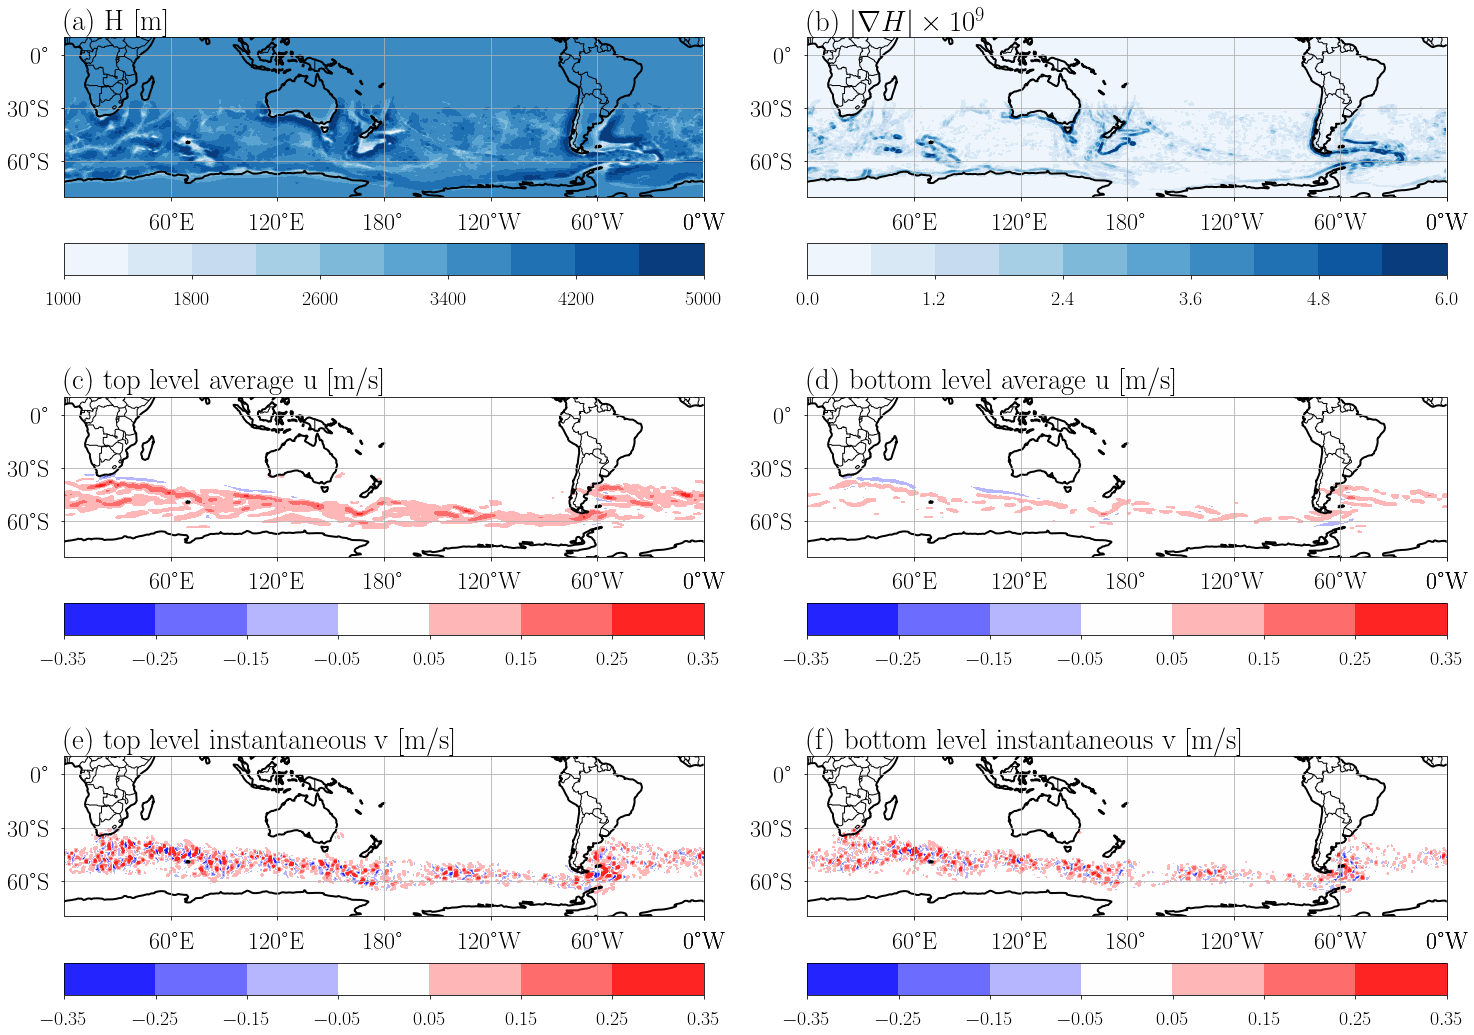

In [9]:
# plot
fig = plt.figure()

ax = plt.subplot(6,2,1,projection=ccrs.PlateCarree(central_longitude=-180))
field = h_physical
h = plot_field(field.T, lon_dns_topo, lat_dns_topo, plot_lat_labels=True, plot_lon_labels=True, minC=1000, maxC=5000, num_contours=11, cmap=plt.cm.Blues);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) H [m]'.format(np.amin(field), np.amax(field)), loc='left'); 

ax = plt.subplot(6,2,2,projection=ccrs.PlateCarree(central_longitude=-180))
field = h_delta_mag
h = plot_field(field.T*1e9, lon_dns_topo, lat_dns_topo, plot_lat_labels=True, plot_lon_labels=True, minC=0.0, maxC=6.0, num_contours=11, cmap=plt.cm.Blues);
plt.title('(b) $| \\nabla H | \\times 10^9$', loc='left'); 
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(u_L1.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) top level average u [m/s]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(u_L2.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) bottom level average u [m/s]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_inst_L1.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) top level instantaneous v [m/s]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_inst_L2.T, lon_dns, lat_dns, plot_lat_labels=True, plot_lon_labels=True, minC=-0.35, maxC=0.35, num_contours=8);
add_plot_features(fig, h, ax, orientation='horizontal',yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) bottom level instantaneous v [m/s]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure1.pdf',bbox_inches='tight')

# DNS kinetic energy spectra

findfont: Font family ['latex'] not found. Falling back to DejaVu Sans.


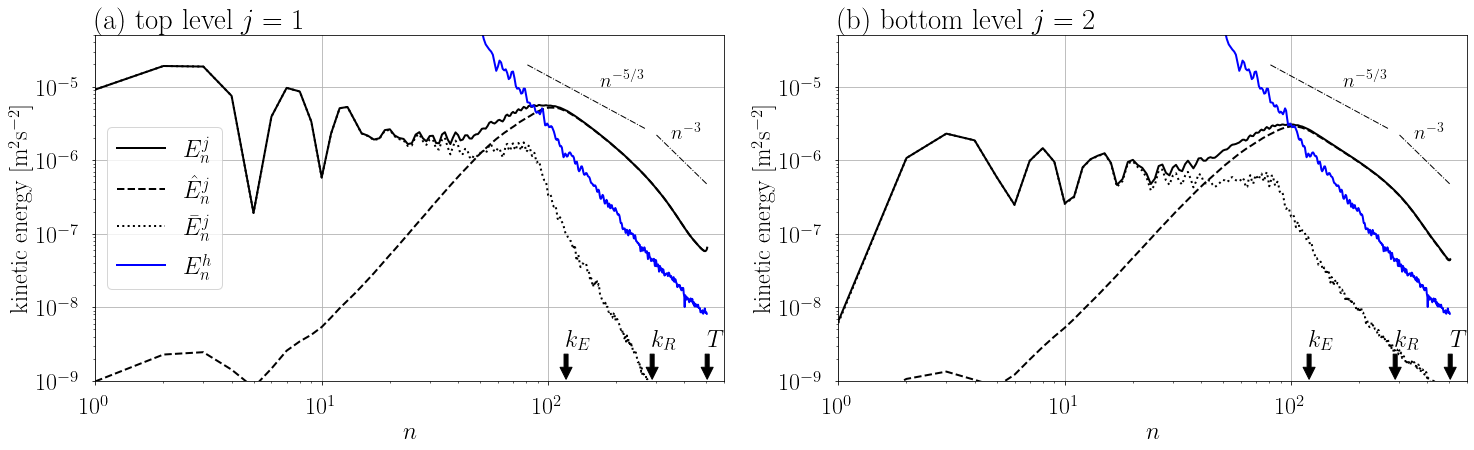

In [10]:
# plot

fig = plt.figure();
xmin  = 1
xmax  = 600

#============================================================
ymin  = 1e-9
ymax  = 5e-5
    
Etot, n = read_spectra(topo_base_dir+'/dns_combined/results/spectra/spectra.energy_k.n.sum')
vort_avg = read_field_aniso(topo_base_dir+'/dns_combined/results/fields/vort.avg')[0]

Eavg = isotropise_field((vort_avg*vort_avg.conj()).real/8.0, calc_avg=False)[:,1:]/n/(n+1.0)*a*a
Eprime = Etot - Eavg

vort_topo = read_topography(topo_base_dir+'/dns34.0000/results/initial_conditions/topography.scaled.dat')[0]
Etopo = (isotropise_topography((np.abs(vort_topo*vort_topo.conj())).real, calc_avg=False)).real[1:]/n/(n+1.0)*a*a

#============================================================
ax = plt.subplot(5,2,1); 
plt.plot(n, Etot[0,:].real, 'k-', linewidth=2, label='$E_n^j$'); 
plt.plot(n, Eprime[0,:].real,'k--', linewidth=2, label='$\\hat{E}_n^j$'); 
plt.plot(n, Eavg[0,:].real,'k:', linewidth=2, label='$\\bar{E}_n^j$'); 

plt.plot(n[:-2], Etopo[:-2].real, 'b-',label='$E_n^h$'); 

plt.plot(n[80:270], 3.0e-2*(n[80:270]**(-5.0/3.0)), 'k-.', linewidth=1); 
ax.text(170, 1e-5, '$n^{-5/3}$', fontsize=20); 

plt.plot(n[300:], 6.0e1*(n[300:]**(-3.0)), 'k-.', linewidth=1); 
ax.text(350, 2e-6, '$n^{-3}$', fontsize=20); 


plt.title('(a) top level $j=1$',loc='left');  plt.grid()
plt.xlabel('$n$'); plt.xlim(xmin,xmax); plt.xscale('log'); 
plt.ylabel('kinetic energy [m$^2$s$^{-2}$]'); plt.yscale('log'); plt.ylim(ymin,ymax); 
plt.legend(loc='center left');

ax.annotate('$k_R$', (288, ymin),
            xytext=(288, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$k_E$', (120, ymin),
            xytext=(120, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$T$', (504, ymin),
            xytext=(504, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

#============================================================
ax = plt.subplot(5,2,2); 
plt.plot(n, Etot[1,:].real, 'k-', linewidth=2, label='$E_n^j$'); 
plt.plot(n, Eprime[1,:].real,'k--', linewidth=2, label='$\\hat{E}_n^j$'); 
plt.plot(n, Eavg[1,:].real,'k:', linewidth=2, label='$\\bar{E}_n^j$'); 

plt.plot(n[80:270], 3.0e-2*(n[80:270]**(-5.0/3.0)), 'k-.', linewidth=1); 
ax.text(170, 1e-5, '$n^{-5/3}$', fontsize=20); 

plt.plot(n[300:], 6.0e1*(n[300:]**(-3.0)), 'k-.', linewidth=1); 
ax.text(350, 2e-6, '$n^{-3}$', fontsize=20); 

plt.plot(n[:-2], Etopo[:-2].real, 'b-',label='$E_n^h$'); 

plt.title('(b) bottom level $j=2$',loc='left');  plt.grid()
plt.xlabel('$n$'); plt.xlim(xmin,xmax); plt.xscale('log'); 
plt.ylabel('kinetic energy [m$^2$s$^{-2}$]'); plt.yscale('log'); plt.ylim(ymin,ymax);

ax.annotate('$k_R$', (288, ymin),
            xytext=(288, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$k_E$', (120, ymin),
            xytext=(120, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

ax.annotate('$T$', (504, ymin),
            xytext=(504, 5*ymin), 
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=24,
            horizontalalignment='left', verticalalignment='top')

plt.tight_layout()

fig.savefig('../images/figure2.pdf',bbox_inches='tight')

# Calculate T_R=252 subgrid coefficients

In [11]:
Tr0=252
Tr=Tr0+1
T_plot=Tr0

topo_base_dir        = data_dir+'/Tr252_tau0288_tauM8000_top'
xyticks = np.linspace(0,250,6)
scale_phys_by=0.35
cbticks_qtS = np.linspace(0,2.0e-7,6)
lev_d = np.linspace(-0.005,0.04,10)
ymin_topo    = -0.012 ; ymax_topo    = 0.024

In [12]:
sgs_topo = SubgridModel()
sgs_topo.read_data(topo_base_dir, read_meanfields=read_meanfields)
sgs_topo.calculate_meanfield_coefficients()
sgs_topo.calculate_eddy_coefficients()

Number of timesteps to calculate of each climate state = 8000
Reading eddy-eddy model
Reading mean subgrid tendencies
Meanfields not yet read from file.
Isotropising subgrid statistics
Calculating dissipation matrices and eigenvalues from anisotropic subgrid statistics
   0 of 253
   10 of 253
   20 of 253
   30 of 253
   40 of 253
   50 of 253
   60 of 253
   70 of 253
   80 of 253
   90 of 253
   100 of 253
   110 of 253
   120 of 253
   130 of 253
   140 of 253
   150 of 253
   160 of 253
   170 of 253
   180 of 253
   190 of 253
   200 of 253
   210 of 253
   220 of 253
   230 of 253
   240 of 253
   250 of 253
   minimum drain eigenvalue =  -0.0062025003
   minimum net eigenvalue =  -0.0050119986
Calculating dissipation matrices and eigenvalues from isotropic subgrid statistics
Isotropising anisotropic dissipation matrices and calculating the eigenvalues


In [13]:
if write_output:
    sgs_topo.write_output_data(topo_base_dir + '/eddy_topographic_model/')

# T_R=252 Fluctuating subgrid tendency

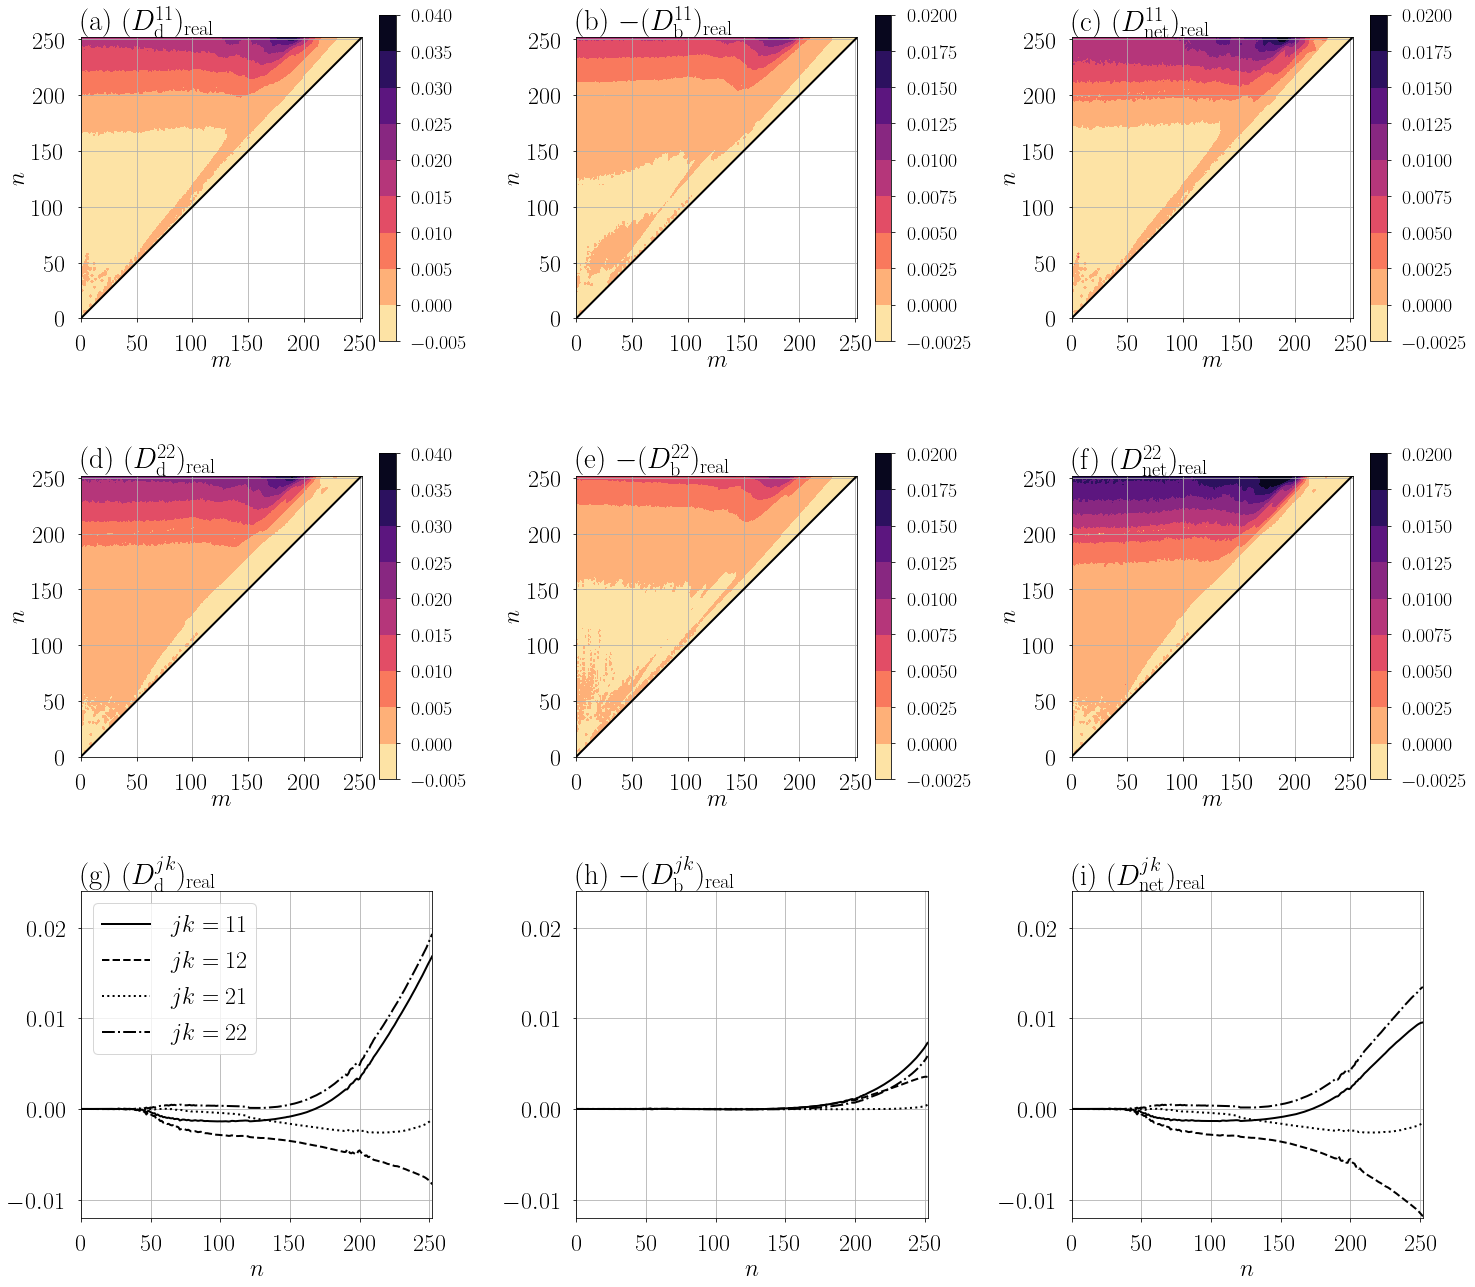

In [14]:
# plot subgrid coefficients
fig = plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_b   = lev_d/2.0
lev_net = lev_d/2.0
    
ax=plt.subplot(5,3,1, aspect='equal')
Z = zero_lower_diagonal(sgs_topo.drain[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
plt.title('(a) $(D^{11}_{\\rm d})_{\\rm real}$',loc='left'); 
del ax, Z

ax=plt.subplot(5,3,4, aspect='equal')
plt.title('(d) $(D^{22}_{\\rm d})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.drain[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,2, aspect='equal')
plt.title('(b) $-(D^{11}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[0,0,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,5, aspect='equal')
plt.title('(e) $-(D^{22}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[1,1,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,3, aspect='equal')
plt.title('(c) $(D^{11}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,6, aspect='equal')
plt.title('(f) $(D^{22}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

# plot eddy-eddy subgrid dissipations isotropised
drain_iso_post_sgs_topo = sgs_topo.drain_iso_post
backscatter_neg_iso_post_sgs_topo = -sgs_topo.backscatter_iso_post
net_iso_post_sgs_topo = sgs_topo.net_iso_post

ax = plt.subplot(5,3,7)
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(g) $(D^{jk}_{\\rm d})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.legend(loc='upper left')
plt.grid()

ax = plt.subplot(5,3,8)
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(h) $-(D^{jk}_{\\rm b})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

ax = plt.subplot(5,3,9)
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(i) $(D^{jk}_{\\rm net})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

plt.tight_layout()

fig.savefig('../images/figure5.pdf',bbox_inches='tight')

#  T_R=252 mean subgrid tendency anisotropic coefficients

In [15]:
scaleby=sgs_topo.omega*sgs_topo.omega
b_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.b')[0]/scaleby
D_q_avg = -read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.negDq')[0]/scaleby
chi_h_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.chiH')[0]/scaleby
f_avg = b_avg - D_q_avg + chi_h_avg

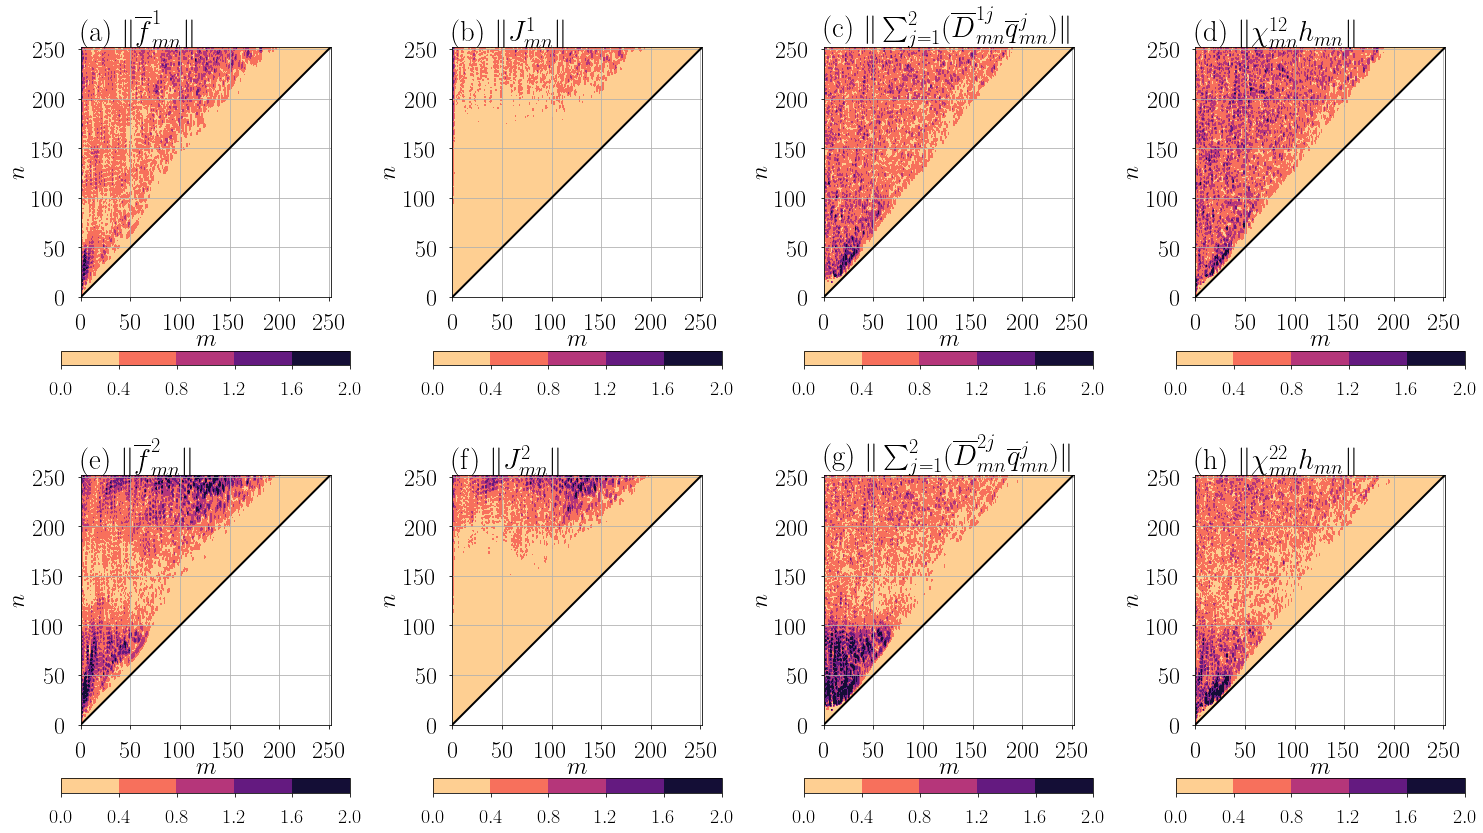

In [16]:
# plot anisotropic mean subgrid tendency

fig =plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_num = 0

ax=plt.subplot(5,4,1, aspect='equal')
plt.title('(a) $\| \\overline{f}^1_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,2, aspect='equal')
plt.title('(b) $\| J^1_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,3, aspect='equal')  
plt.title('(c) $\| \sum_{j=1}^2 (\\overline{D}^{1j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,4, aspect='equal')
plt.title('(d) $\| \chi^{12}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


lev_num = 1

ax=plt.subplot(5,4,5, aspect='equal')
plt.title('(e) $\| \\overline{f}^2_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,6, aspect='equal')
plt.title('(f) $\| J^2_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,7, aspect='equal')  
plt.title('(g) $\| \sum_{j=1}^2 (\\overline{D}^{2j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,8, aspect='equal')
plt.title('(h) $\| \chi^{22}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


plt.tight_layout()

fig.savefig('../images/figure7.pdf',bbox_inches='tight')

# T_R=252 mean subgrid tendency physical fields

In [17]:
# reconstruct fields
T_plot = sgs_topo.Tr_n-1
T_recon=T_plot
lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)

filename = topo_base_dir + '/eddy_topographic_model/vort.f'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
T_dns = len(n_dns)-1
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')
strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_f = -strm_L1_dy; v_L1_f = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_f = -strm_L2_dy; v_L2_f = strm_L2_dx
strm_L1_f = copy.deepcopy(strm_L1)
strm_L2_f = copy.deepcopy(strm_L2)
vort_L1_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_f = (v_L1_f + v_L2_f)/2.0
vort_BT_f = (vort_L1_f + vort_L2_f)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.b'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_b = -strm_L1_dy; v_L1_b = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_b = -strm_L2_dy; v_L2_b = strm_L2_dx
strm_L1_b = copy.deepcopy(strm_L1)
strm_L2_b = copy.deepcopy(strm_L2)
vort_L1_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_b = (v_L1_b + v_L2_b)/2.0
vort_BT_b = (vort_L1_b + vort_L2_b)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.chiH'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_chiH = -strm_L1_dy; v_L1_chiH = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_chiH = -strm_L2_dy; v_L2_chiH = strm_L2_dx
strm_L1_chiH = copy.deepcopy(strm_L1)
strm_L2_chiH = copy.deepcopy(strm_L2)
vort_L1_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_chiH = (v_L1_chiH + v_L2_chiH)/2.0
vort_BT_chiH = (vort_L1_chiH + vort_L2_chiH)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.neg_Dq'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_negDq = -strm_L1_dy; v_L1_negDq = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_negDq = -strm_L2_dy; v_L2_negDq = strm_L2_dx
strm_L1_negDq = copy.deepcopy(strm_L1)
strm_L2_negDq = copy.deepcopy(strm_L2)
vort_L1_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_negDq = (v_L1_negDq + v_L2_negDq)/2.0
vort_BT_negDq = (vort_L1_negDq + vort_L2_negDq)/2.0

MIN= -2.366793  MAX= 2.3991318
MIN= -0.798604  MAX= 0.7993441
MIN= -1.22989  MAX= 1.2592025
MIN= -0.49378973  MAX= 0.58867437
MIN= -2.0763202  MAX= 2.2207267
MIN= -0.43085858  MAX= 0.31062979
MIN= -2.1056714  MAX= 1.7879276
MIN= -0.5303075  MAX= 0.65017307


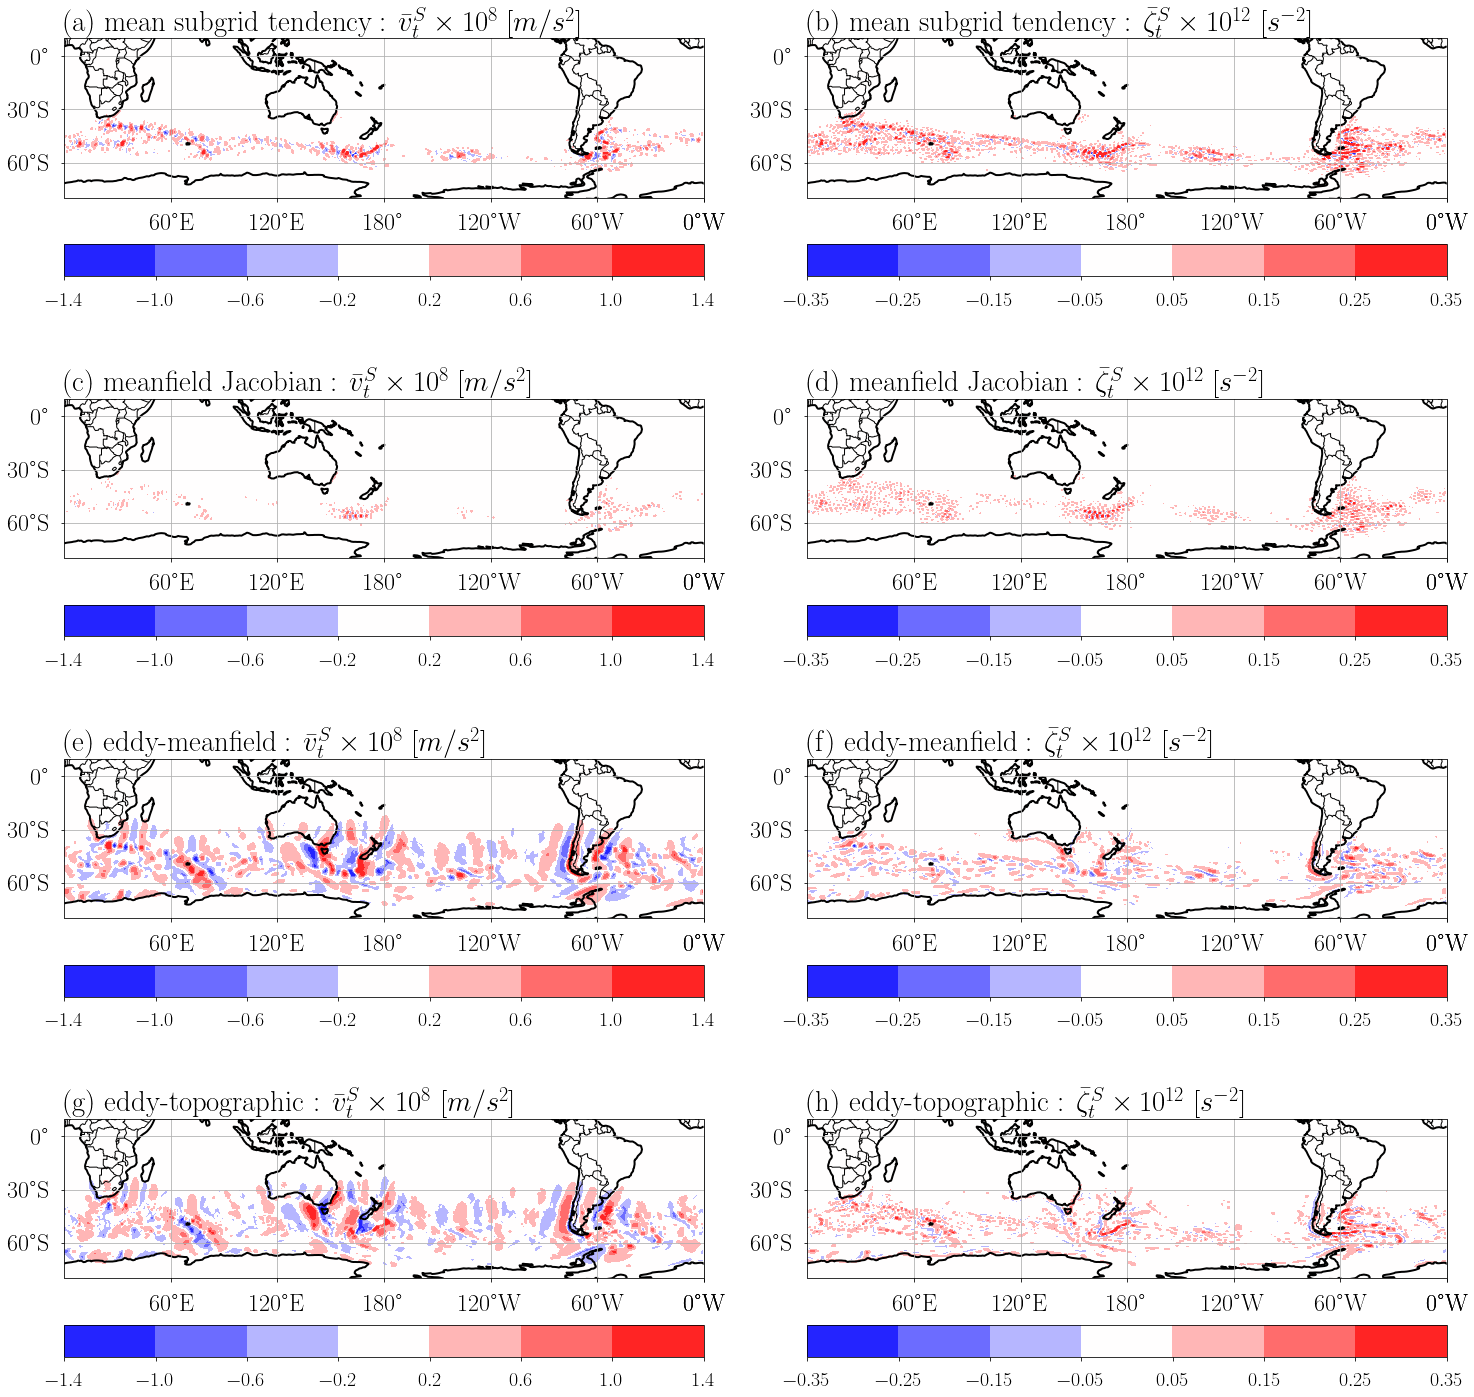

In [18]:
# plot
fig = plt.figure()

num_contours=8

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_f[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) mean subgrid tendency : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_f[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(b) mean subgrid tendency : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_b[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) meanfield Jacobian : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_b[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) meanfield Jacobian : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,7,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_negDq[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=-2, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) eddy-meanfield : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,8,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_negDq[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) eddy-meanfield : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,9,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_chiH[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(g) eddy-topographic : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,10,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_chiH[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10, borders=True, coasts=True)
plt.title('(h) eddy-topographic : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure9.pdf',bbox_inches='tight')

# Calculate TR=378 subgrid coefficients

In [19]:
Tr0=378
Tr=Tr0+1
T_plot=Tr0

topo_base_dir        = data_dir+'/Tr378_tau0192_tauM8000_top'
xyticks = np.linspace(0,300,4)
scale_phys_by = 0.14
cbticks_qtS = np.linspace(0,8.0e-8,6)
lev_d = np.linspace(-0.005,0.04,10)*2.0
ymin_topo    = -0.02 ; ymax_topo    = 0.045

In [20]:
sgs_topo = SubgridModel()
sgs_topo.read_data(topo_base_dir, read_meanfields=read_meanfields)
sgs_topo.calculate_meanfield_coefficients()
sgs_topo.calculate_eddy_coefficients()

Number of timesteps to calculate of each climate state = 8000
Reading eddy-eddy model
Reading mean subgrid tendencies
Meanfields not yet read from file.
Isotropising subgrid statistics
Calculating dissipation matrices and eigenvalues from anisotropic subgrid statistics
   0 of 379
   10 of 379
   20 of 379
   30 of 379
   40 of 379
   50 of 379
   60 of 379
   70 of 379
   80 of 379
   90 of 379
   100 of 379
   110 of 379
   120 of 379
   130 of 379
   140 of 379
   150 of 379
   160 of 379
   170 of 379
   180 of 379
   190 of 379
   200 of 379
   210 of 379
   220 of 379
   230 of 379
   240 of 379
   250 of 379
   260 of 379
   270 of 379
   280 of 379
   290 of 379
   300 of 379
   310 of 379
   320 of 379
   330 of 379
   340 of 379
   350 of 379
   360 of 379
   370 of 379
   minimum drain eigenvalue =  -0.0023415624
   minimum net eigenvalue =  -0.0036089541
Calculating dissipation matrices and eigenvalues from isotropic subgrid statistics
Isotropising anisotropic dissipation m

In [21]:
if write_output:
    sgs_topo.write_output_data(topo_base_dir + '/eddy_topographic_model/')

# T_R=378 Fluctuating subgrid tendency

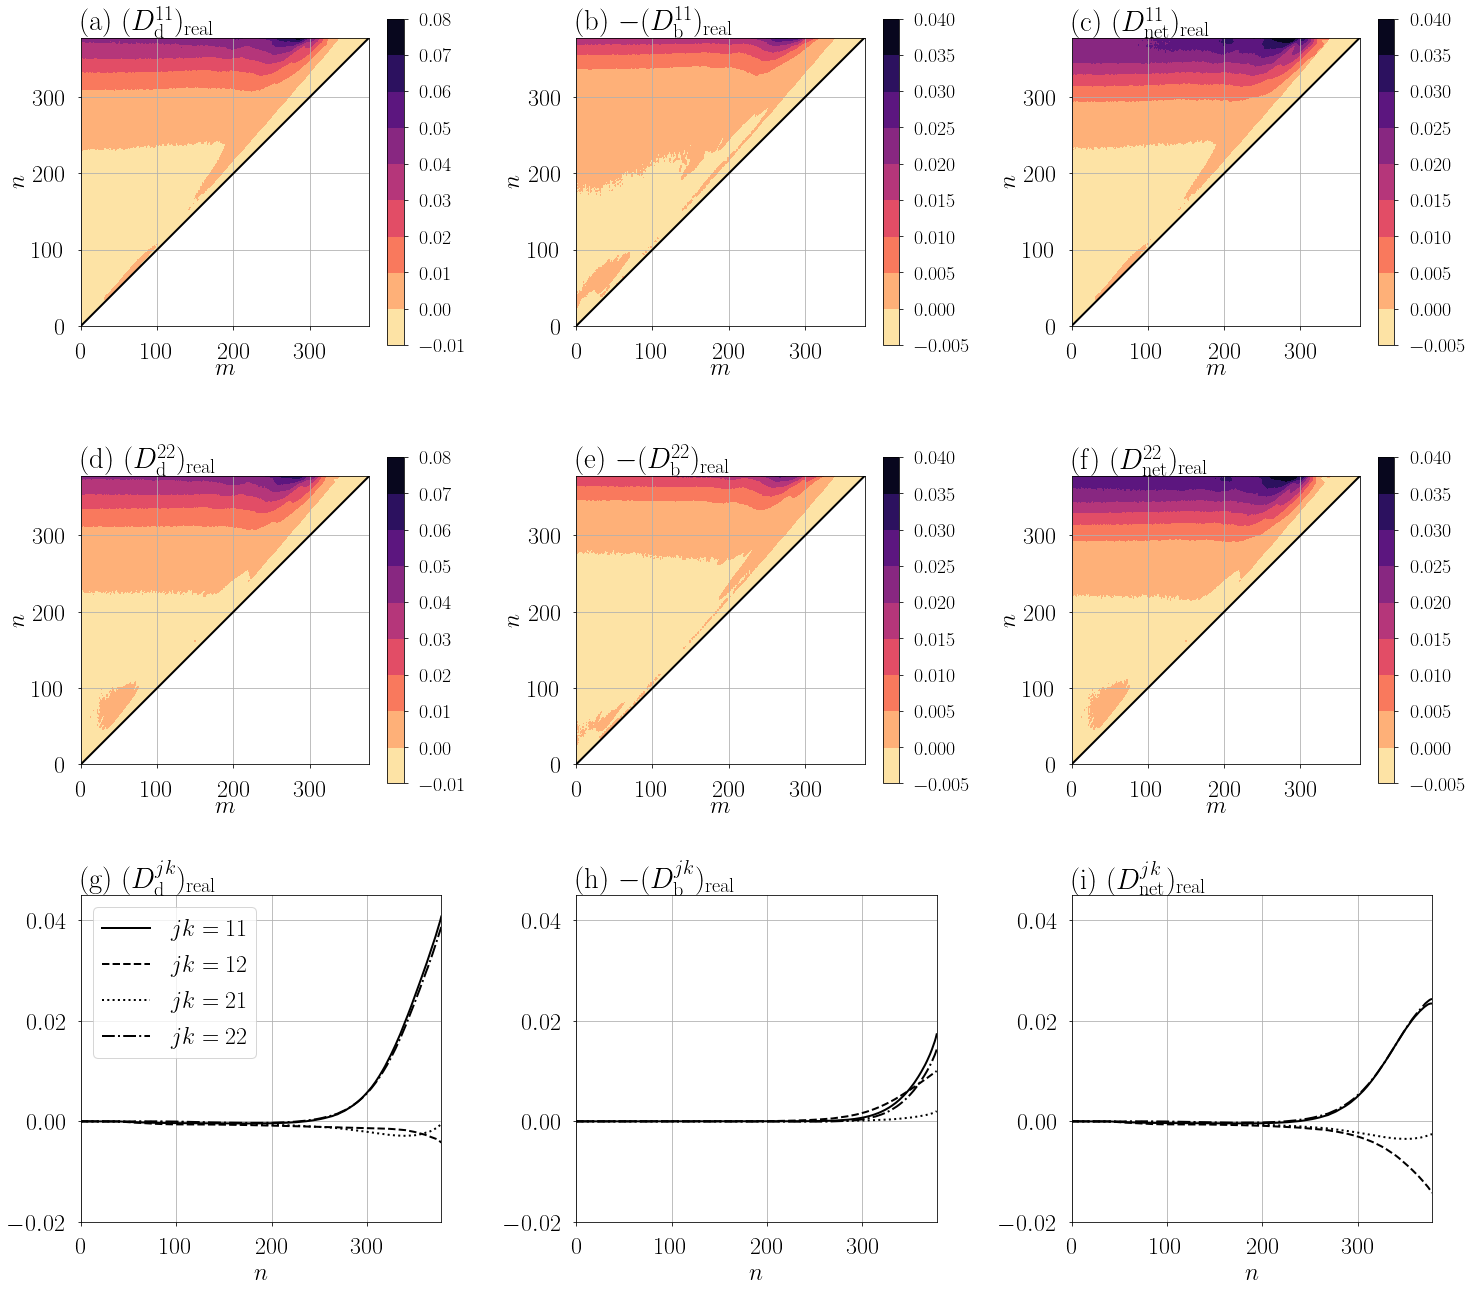

In [22]:
# plot subgrid coefficients
fig = plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_b   = lev_d/2.0
lev_net = lev_d/2.0
    
ax=plt.subplot(5,3,1, aspect='equal')
Z = zero_lower_diagonal(sgs_topo.drain[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
plt.title('(a) $(D^{11}_{\\rm d})_{\\rm real}$',loc='left'); 
del ax, Z

ax=plt.subplot(5,3,4, aspect='equal')
plt.title('(d) $(D^{22}_{\\rm d})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.drain[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_d, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,2, aspect='equal')
plt.title('(b) $-(D^{11}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[0,0,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,5, aspect='equal')
plt.title('(e) $-(D^{22}_{\\rm b})_{\\rm real}$',loc='left'); 
Z = -zero_lower_diagonal(sgs_topo.backscatter[1,1,:,:].real.T)    
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_b, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,3, aspect='equal')
plt.title('(c) $(D^{11}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[0,0,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z

ax=plt.subplot(5,3,6, aspect='equal')
plt.title('(f) $(D^{22}_{\\rm net})_{\\rm real}$',loc='left'); 
Z = zero_lower_diagonal(sgs_topo.net[1,1,:,:].real.T)
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, lev_net, xyticks, cmap=plt.cm.magma_r)
del ax, Z


# plot eddy-eddy subgrid dissipations isotropised
drain_iso_post_sgs_topo = sgs_topo.drain_iso_post
backscatter_neg_iso_post_sgs_topo = -sgs_topo.backscatter_iso_post
net_iso_post_sgs_topo = sgs_topo.net_iso_post

ax = plt.subplot(5,3,7)
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, drain_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(g) $(D^{jk}_{\\rm d})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.legend(loc='upper left')
plt.grid()

ax = plt.subplot(5,3,8)
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, backscatter_neg_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(h) $-(D^{jk}_{\\rm b})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

ax = plt.subplot(5,3,9)
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,0,:].real, 'k-',  label='$jk=11$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[0,1,:].real, 'k--', label='$jk=12$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,0,:].real, 'k:',  label='$jk=21$')
plt.plot(sgs_topo.n, net_iso_post_sgs_topo[1,1,:].real, 'k-.', label='$jk=22$')
plt.xlabel('$n$'); 
plt.title('(i) $(D^{jk}_{\\rm net})_{\\rm real}$', loc='left')
plt.ylim(ymin_topo,ymax_topo)
plt.xticks(xyticks)
plt.xlim(sgs_topo.n[0],sgs_topo.n[-1])
plt.grid()

plt.tight_layout()

fig.savefig('../images/figure6.pdf',bbox_inches='tight')

#  T_R=378 mean subgrid tendency anisotropic coefficients

In [23]:
scaleby=sgs_topo.omega*sgs_topo.omega
b_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.b')[0]/scaleby
D_q_avg = -read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.negDq')[0]/scaleby
chi_h_avg = read_field_aniso(topo_base_dir + '/eddy_topographic_model/red_vort_subgrid_tend.avg_trunc.chiH')[0]/scaleby
f_avg = b_avg - D_q_avg + chi_h_avg

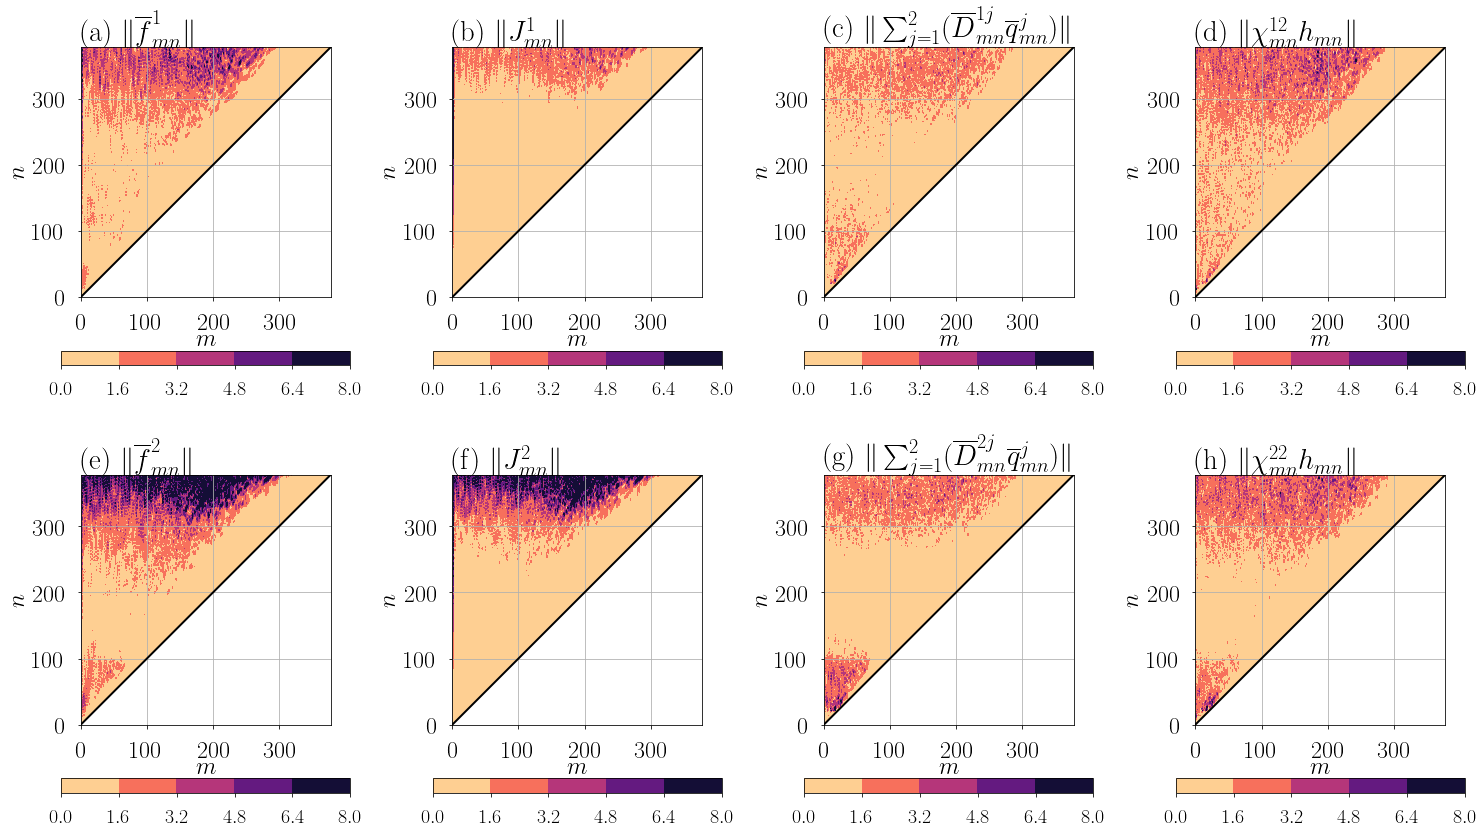

In [24]:
# plot anisotropic mean subgrid tendency

fig =plt.figure();
plt.rcParams['figure.figsize'] = (21, 30)  # A4
plt.rcParams['font.size'] = 24

lev_num = 0

ax=plt.subplot(5,4,1, aspect='equal')
plt.title('(a) $\| \\overline{f}^1_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,2, aspect='equal')
plt.title('(b) $\| J^1_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,3, aspect='equal')  
plt.title('(c) $\| \sum_{j=1}^2 (\\overline{D}^{1j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,4, aspect='equal')
plt.title('(d) $\| \chi^{12}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


lev_num = 1

ax=plt.subplot(5,4,5, aspect='equal')
plt.title('(e) $\| \\overline{f}^2_{mn} \|$',loc='left'); 
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(f_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,6, aspect='equal')
plt.title('(f) $\| J^2_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(b_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,7, aspect='equal')  
plt.title('(g) $\| \sum_{j=1}^2 (\\overline{D}^{2j}_{mn} \\overline{q}^{j}_{mn}) \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(D_q_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z

ax=plt.subplot(5,4,8, aspect='equal')
plt.title('(h) $\| \chi^{22}_{mn} h_{mn} \|$',loc='left');
Z = np.sqrt(zero_lower_diagonal(np.real(np.abs(chi_h_avg[lev_num,:,:].T))**2.0))
plot_aniso_subgrid_coef(ax, Z, sgs_topo.n, sgs_topo.m, cbticks_qtS, xyticks, cmap=plt.cm.magma_r, orientation='horizontal')
del ax, Z


plt.tight_layout()

fig.savefig('../images/figure8.pdf',bbox_inches='tight')

# T_R=378 mean subgrid tendency physical fields

In [25]:
# reconstruct fields
T_plot = sgs_topo.Tr_n-1
T_recon=T_plot

lat_dns_topo, lon_dns_topo = calculate_grid(T_plot)

filename = topo_base_dir + '/eddy_topographic_model/vort.f'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
T_dns = len(n_dns)-1
lat_dns, lon_dns = calculate_grid(T_dns)
spharm_dns = spharm.Spharmt(nlat=len(lat_dns), nlon=len(lon_dns), gridtype='gaussian')
strm = copy.deepcopy(vort_spectral_2d)
a=6.371e6
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_f = -strm_L1_dy; v_L1_f = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_f = -strm_L2_dy; v_L2_f = strm_L2_dx
strm_L1_f = copy.deepcopy(strm_L1)
strm_L2_f = copy.deepcopy(strm_L2)
vort_L1_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_f = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_f = (v_L1_f + v_L2_f)/2.0
vort_BT_f = (vort_L1_f + vort_L2_f)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.b'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_b = -strm_L1_dy; v_L1_b = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_b = -strm_L2_dy; v_L2_b = strm_L2_dx
strm_L1_b = copy.deepcopy(strm_L1)
strm_L2_b = copy.deepcopy(strm_L2)
vort_L1_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_b = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_b = (v_L1_b + v_L2_b)/2.0
vort_BT_b = (vort_L1_b + vort_L2_b)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.chiH'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_chiH = -strm_L1_dy; v_L1_chiH = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_chiH = -strm_L2_dy; v_L2_chiH = strm_L2_dx
strm_L1_chiH = copy.deepcopy(strm_L1)
strm_L2_chiH = copy.deepcopy(strm_L2)
vort_L1_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_chiH = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_chiH = (v_L1_chiH + v_L2_chiH)/2.0
vort_BT_chiH = (vort_L1_chiH + vort_L2_chiH)/2.0

filename = topo_base_dir + '/eddy_topographic_model/vort.neg_Dq'
vort_spectral_2d, n_dns, m_dns = read_field_aniso(filename)
vort_spectral_2d[:, T_recon:, :] = 0.0
vort_spectral_2d[:, :, T_recon:] = 0.0
strm = copy.deepcopy(vort_spectral_2d)
for ii in range(1,T_dns):
    laplacian = -1.0*ii*(ii+1)/a/a
    strm[:,:,ii] = strm[:,:,ii]/laplacian
strm_L1 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
strm_L1_dx, strm_L1_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[0,:,:], T_dns))
u_L1_negDq = -strm_L1_dy; v_L1_negDq = strm_L1_dx
strm_L2 = spharm_dns.spectogrd(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
strm_L2_dx, strm_L2_dy = spharm_dns.getgrad(convert_spect_2d_to_1d(strm[1,:,:], T_dns))
u_L2_negDq = -strm_L2_dy; v_L2_negDq = strm_L2_dx
strm_L1_negDq = copy.deepcopy(strm_L1)
strm_L2_negDq = copy.deepcopy(strm_L2)
vort_L1_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[0,:,:], T_dns))
vort_L2_negDq = spharm_dns.spectogrd(convert_spect_2d_to_1d(vort_spectral_2d[1,:,:], T_dns))
v_BT_negDq = (v_L1_negDq + v_L2_negDq)/2.0
vort_BT_negDq = (vort_L1_negDq + vort_L2_negDq)/2.0

MIN= -1.2414405  MAX= 1.4071276
MIN= -0.86961555  MAX= 0.71844864
MIN= -1.1879665  MAX= 1.2471219
MIN= -0.6894882  MAX= 0.705579
MIN= -0.51148754  MAX= 0.6603488
MIN= -0.16651557  MAX= 0.10575952
MIN= -0.65768385  MAX= 0.54486346
MIN= -0.27490896  MAX= 0.34238783


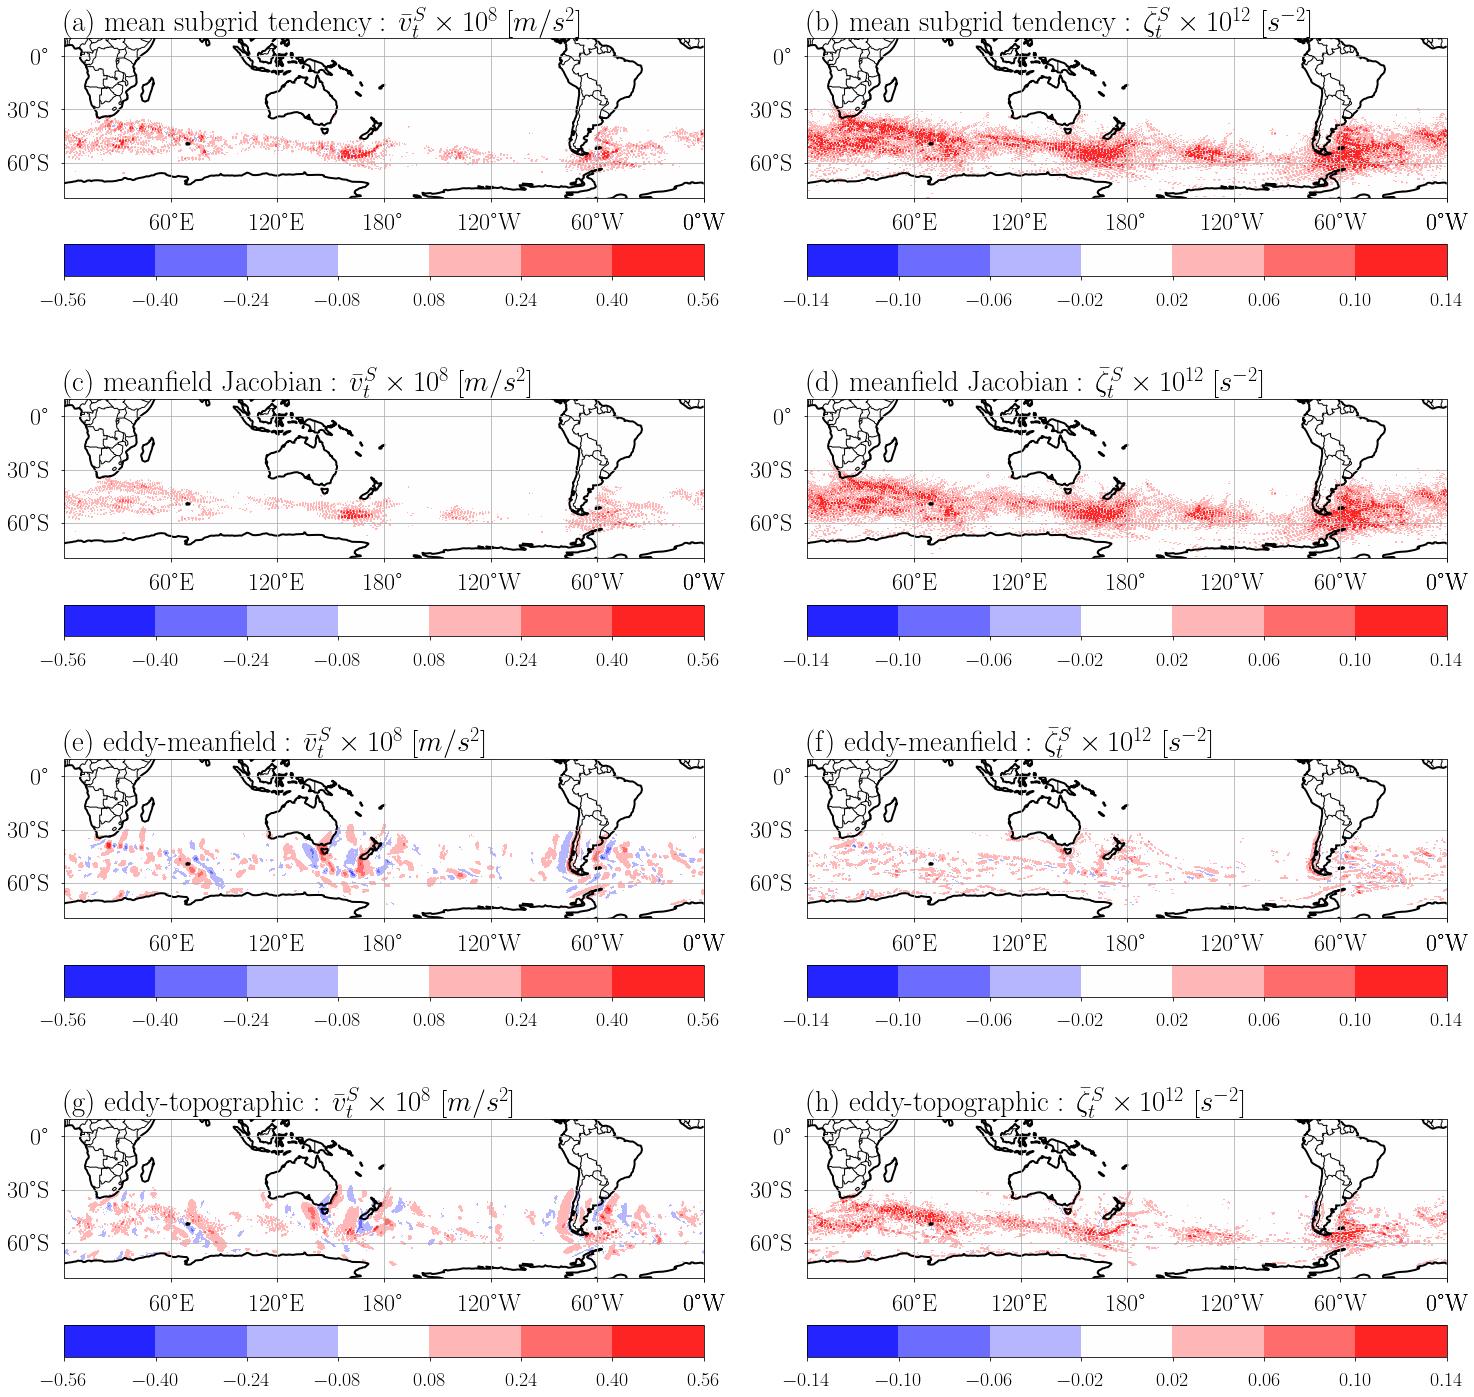

In [26]:
# plot
fig = plt.figure()

num_contours=8

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_f[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) mean subgrid tendency : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_f[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(b) mean subgrid tendency : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_b[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(c) meanfield Jacobian : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_b[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(d) meanfield Jacobian : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,7,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_negDq[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=-2, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(e) eddy-meanfield : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,8,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_negDq[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(f) eddy-meanfield : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

ax = plt.subplot(6,2,9,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(v_BT_chiH[20:-20,:].T*1e8, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by*4, maxC=scale_phys_by*4, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(g) eddy-topographic : $\\bar{v}_t^S \\times 10^{8}$ [$m/s^2$]', loc='left'); 

ax = plt.subplot(6,2,10,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(vort_BT_chiH[20:-20,:].T*1e12, lon_dns_topo, lat_dns_topo[20:-20], plot_lat_labels=True, plot_lon_labels=True, minC=-scale_phys_by, maxC=scale_phys_by, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10, borders=True, coasts=True)
plt.title('(h) eddy-topographic : $\\bar{\\zeta}_t^S \\times 10^{12}$ [$s^{-2}$]', loc='left'); 

plt.tight_layout()

fig.savefig('../images/figure10.pdf',bbox_inches='tight')

# Comparison of DNS and LES kinetic energy spectra

* LES with subgrid eddy-eddy, eddy-meanfield, eddy-topographic
* LES with subgrid eddy-eddy, eddy-meanfield
* LES with subgrid eddy-eddy

In [27]:
var_name='energy_k'

exp_dir              = data_dir+'/Tr378_tau0192_tauM8000_top'
DNS_Etot, DNS_n, DNS_Etot_min, DNS_Etot_max = read_spectra(exp_dir + '/dns_combined/results/spectra/spectra.'+var_name+'.n.sum', read_min_max=True)
AD_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoDeter_combined/results/spectra/spectra.'+var_name+'.n.sum')
ADNoMean_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoDeterNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
AS_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoStoch_combined/results/spectra/spectra.'+var_name+'.n.sum')
ASNoMean_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/anisoStochNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
NoSGS_Etot_Tr378, LES_n_Tr378 = read_spectra(exp_dir + '/noSGS_combined/results/spectra/spectra.'+var_name+'.n.sum')

exp_dir              = data_dir+'/Tr252_tau0288_tauM8000_top'
AD_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoDeter_combined/results/spectra/spectra.'+var_name+'.n.sum')
ADNoMean_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoDeterNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
AS_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoStoch_combined/results/spectra/spectra.'+var_name+'.n.sum')
ASNoMean_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/anisoStochNoMean_combined/results/spectra/spectra.'+var_name+'.n.sum')
NoSGS_Etot_Tr252, LES_n_Tr252 = read_spectra(exp_dir + '/noSGS_combined/results/spectra/spectra.'+var_name+'.n.sum')

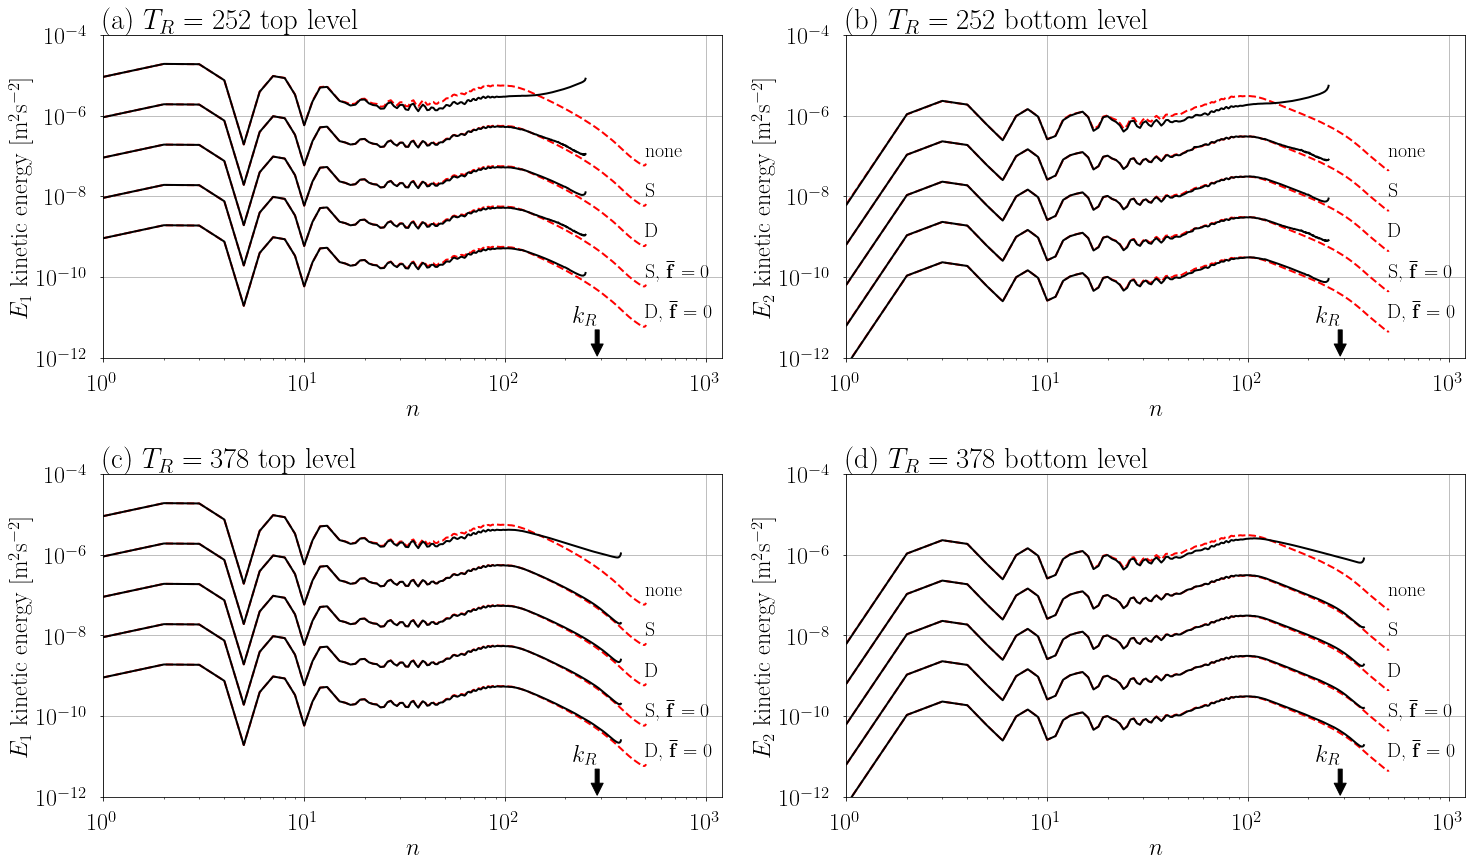

In [28]:
# plot kinetic energy
fig = plt.figure();

ax = plt.subplot(5,2,1);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr252, DNS_Etot[0,:], NoSGS_Etot_Tr252[0,:], AS_Etot_Tr252[0,:], AD_Etot_Tr252[0,:], ASNoMean_Etot_Tr252[0,:], ADNoMean_Etot_Tr252[0,:], DNS_Etot_min[0,:], DNS_Etot_max[0,:])
plt.title('(a) $T_R=252$ top level',loc='left');
plt.ylabel('$E_1$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,2);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr252, DNS_Etot[1,:], NoSGS_Etot_Tr252[1,:], AS_Etot_Tr252[1,:], AD_Etot_Tr252[1,:], ASNoMean_Etot_Tr252[1,:], ADNoMean_Etot_Tr252[1,:], DNS_Etot_min[1,:], DNS_Etot_max[1,:])
plt.title('(b) $T_R=252$ bottom level',loc='left');
plt.ylabel('$E_2$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,3);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr378, DNS_Etot[0,:], NoSGS_Etot_Tr378[0,:], AS_Etot_Tr378[0,:], AD_Etot_Tr378[0,:], ASNoMean_Etot_Tr378[0,:], ADNoMean_Etot_Tr378[0,:], DNS_Etot_min[0,:], DNS_Etot_max[0,:])
plt.title('(c) $T_R=378$ top level',loc='left');
plt.ylabel('$E_1$ kinetic energy [m$^2$s$^{-2}$]');

ax = plt.subplot(5,2,4);
plot_spectra_comparison(ax, DNS_n, LES_n_Tr378, DNS_Etot[1,:], NoSGS_Etot_Tr378[1,:], AS_Etot_Tr378[1,:], AD_Etot_Tr378[1,:], ASNoMean_Etot_Tr378[1,:], ADNoMean_Etot_Tr378[1,:], DNS_Etot_min[1,:], DNS_Etot_max[1,:])
plt.title('(d) $T_R=378$ bottom level',loc='left');
plt.ylabel('$E_2$ kinetic energy [m$^2$s$^{-2}$]');

plt.tight_layout()

fig.savefig('../images/figure11.pdf',bbox_inches='tight')

# Ratios of DNS and LES kinetic energy spectra

findfont: Font family ['latex'] not found. Falling back to DejaVu Sans.


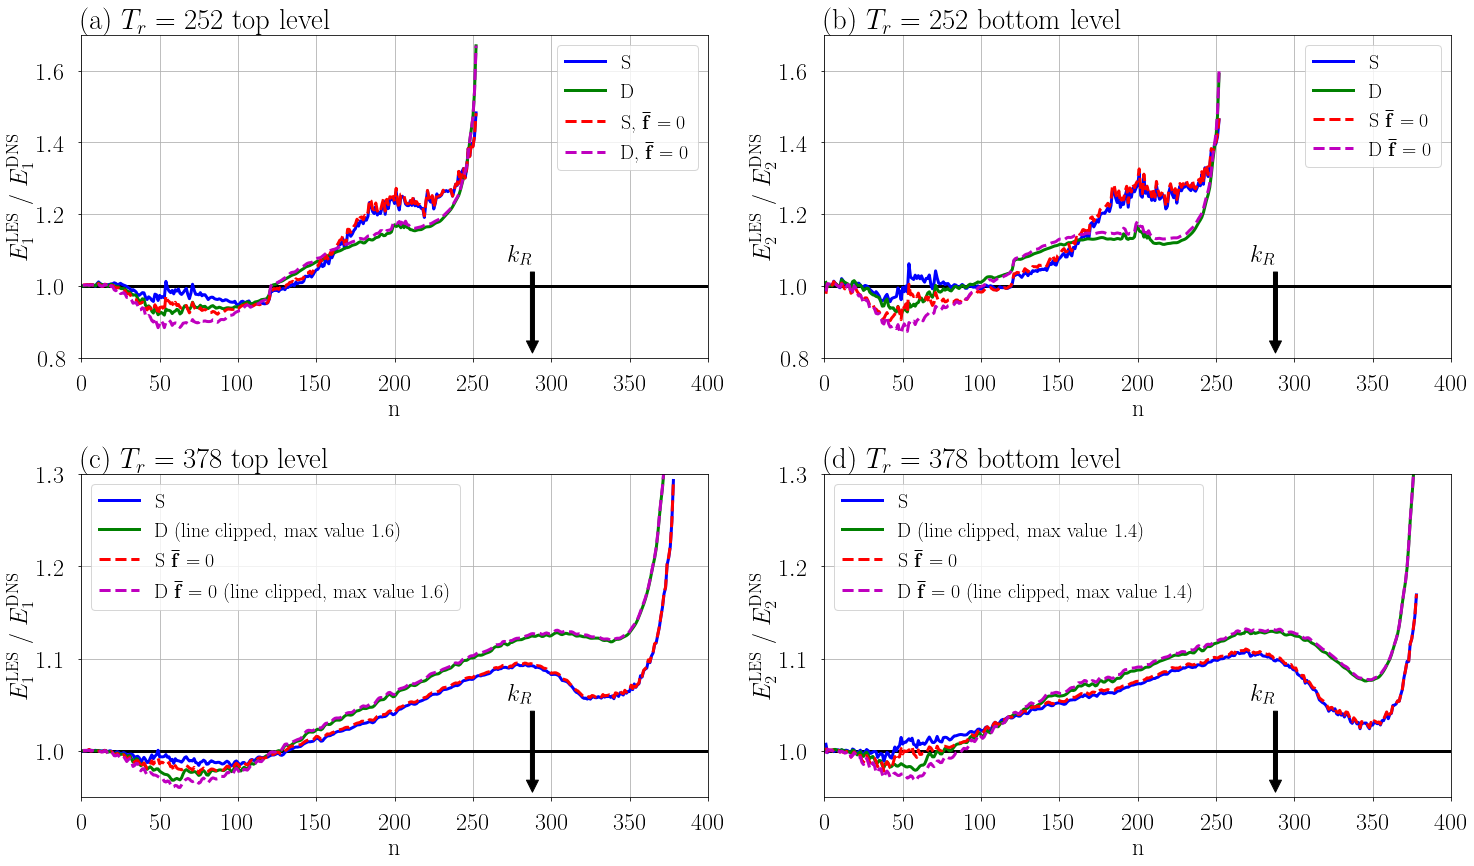

In [29]:
# total spectra
fig = plt.figure();

xmin=0 ; xmax=400

ax = plt.subplot(5,2,1)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr252, (AS_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr252, (AD_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '-g', label='D', lw=3)
plt.plot(LES_n_Tr252, (ASNoMean_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '--r', label='S, $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr252, (ADNoMean_Etot_Tr252[0,:]/DNS_Etot[0,:len(LES_n_Tr252)]), '--m', label='D, $\\mathbf{\\bar{f}}=0$', lw=3)
plt.title('(a) $T_r=252$ top level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_1^{\\rm LES}$ / $E_1^{\\rm DNS}$')
plt.grid()
plt.legend(loc='upper right', fontsize=20)
plt.ylim(0.8,1.7)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.8),
        xytext=(288, 1.057), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')

ax = plt.subplot(5,2,2)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr252, (AS_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr252, (AD_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '-g', label='D', lw=3)
plt.plot(LES_n_Tr252, (ASNoMean_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr252, (ADNoMean_Etot_Tr252[1,:]/DNS_Etot[1,:len(LES_n_Tr252)]), '--m', label='D $\\mathbf{\\bar{f}}=0$', lw=3)
plt.title('(b) $T_r=252$ bottom level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_2^{\\rm LES}$ / $E_2^{\\rm DNS}$')
plt.grid()
plt.legend(loc='upper right', fontsize=20)
plt.ylim(0.8,1.7)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.8),
        xytext=(288, 1.057), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')

ax = plt.subplot(5,2,3)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr378, (AS_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr378, (AD_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '-g', label='D (line clipped, max value 1.6)', lw=3)
plt.plot(LES_n_Tr378, (ASNoMean_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr378, (ADNoMean_Etot_Tr378[0,:]/DNS_Etot[0,:len(LES_n_Tr378)]), '--m', label='D $\\mathbf{\\bar{f}}=0$  (line clipped, max value 1.6)', lw=3)
plt.title('(c) $T_r=378$ top level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_1^{\\rm LES}$ / $E_1^{\\rm DNS}$')
plt.grid()
plt.ylim(0.95,1.3)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.95),
        xytext=(288, 1.05), 
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')
plt.legend(loc='upper left', fontsize=20)

ax = plt.subplot(5,2,4)
plt.plot([xmin,xmax], [1,1], '-k', lw=3)
plt.plot(LES_n_Tr378, (AS_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '-b', label='S', lw=3)
plt.plot(LES_n_Tr378, (AD_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '-g', label='D  (line clipped, max value 1.4)', lw=3)
plt.plot(LES_n_Tr378, (ASNoMean_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '--r', label='S $\\mathbf{\\bar{f}}=0$', lw=3)
plt.plot(LES_n_Tr378, (ADNoMean_Etot_Tr378[1,:]/DNS_Etot[1,:len(LES_n_Tr378)]), '--m', label='D $\\mathbf{\\bar{f}}=0$  (line clipped, max value 1.4)', lw=3)
plt.title('(d) $T_r=378$ bottom level',loc='left');
plt.xlabel('n')
plt.ylabel('$E_2^{\\rm LES}$ / $E_2^{\\rm DNS}$')
plt.grid()
plt.ylim(0.95,1.3)
plt.xlim(xmin,xmax)
ax.annotate('$k_R$', (288, 0.95),
        xytext=(288, 1.05),
        arrowprops=dict(facecolor='black', shrink=0.05),
        fontsize=24,
        horizontalalignment='right', verticalalignment='bottom')
plt.legend(loc='upper left', fontsize=20)
    
plt.tight_layout()

fig.savefig('../images/figure12.pdf',bbox_inches='tight')

# Comparison of DNS and LES average fields

In [30]:
topo_base_dir        = data_dir+'/Tr252_tau0288_tauM8000_top'
filename_dns = topo_base_dir+'/dns_combined/results/fields/vort.avg'
filename_AS = topo_base_dir+'/anisoStoch_combined/results/fields/vort.avg'
filename_AD = topo_base_dir+'/anisoDeter_combined/results/fields/vort.avg'
filename_ASNoM = topo_base_dir+'/anisoStochNoMean_combined/results/fields/vort.avg'
filename_ADNoM = topo_base_dir+'/anisoDeterNoMean_combined/results/fields/vort.avg'
filename_noSGS = topo_base_dir+'/noSGS_combined/results/fields/vort.avg'

In [31]:
# get meanfield data
output_dns   = get_physical_fields(filename_dns)
output_AS    = get_physical_fields(filename_AS)
output_AD    = get_physical_fields(filename_AD)
output_ASNoM = get_physical_fields(filename_ASNoM)
output_ADNoM = get_physical_fields(filename_ADNoM)
output_NoSGS = get_physical_fields(filename_noSGS)

MIN= -0.14215226  MAX= 0.19546184
MIN= -0.04057312  MAX= 0.03216111
MIN= -0.010984048  MAX= 0.01175499
MIN= -0.007876821  MAX= 0.008138515
MIN= -0.012545943  MAX= 0.012614569
MIN= -0.017823368  MAX= 0.0151758455


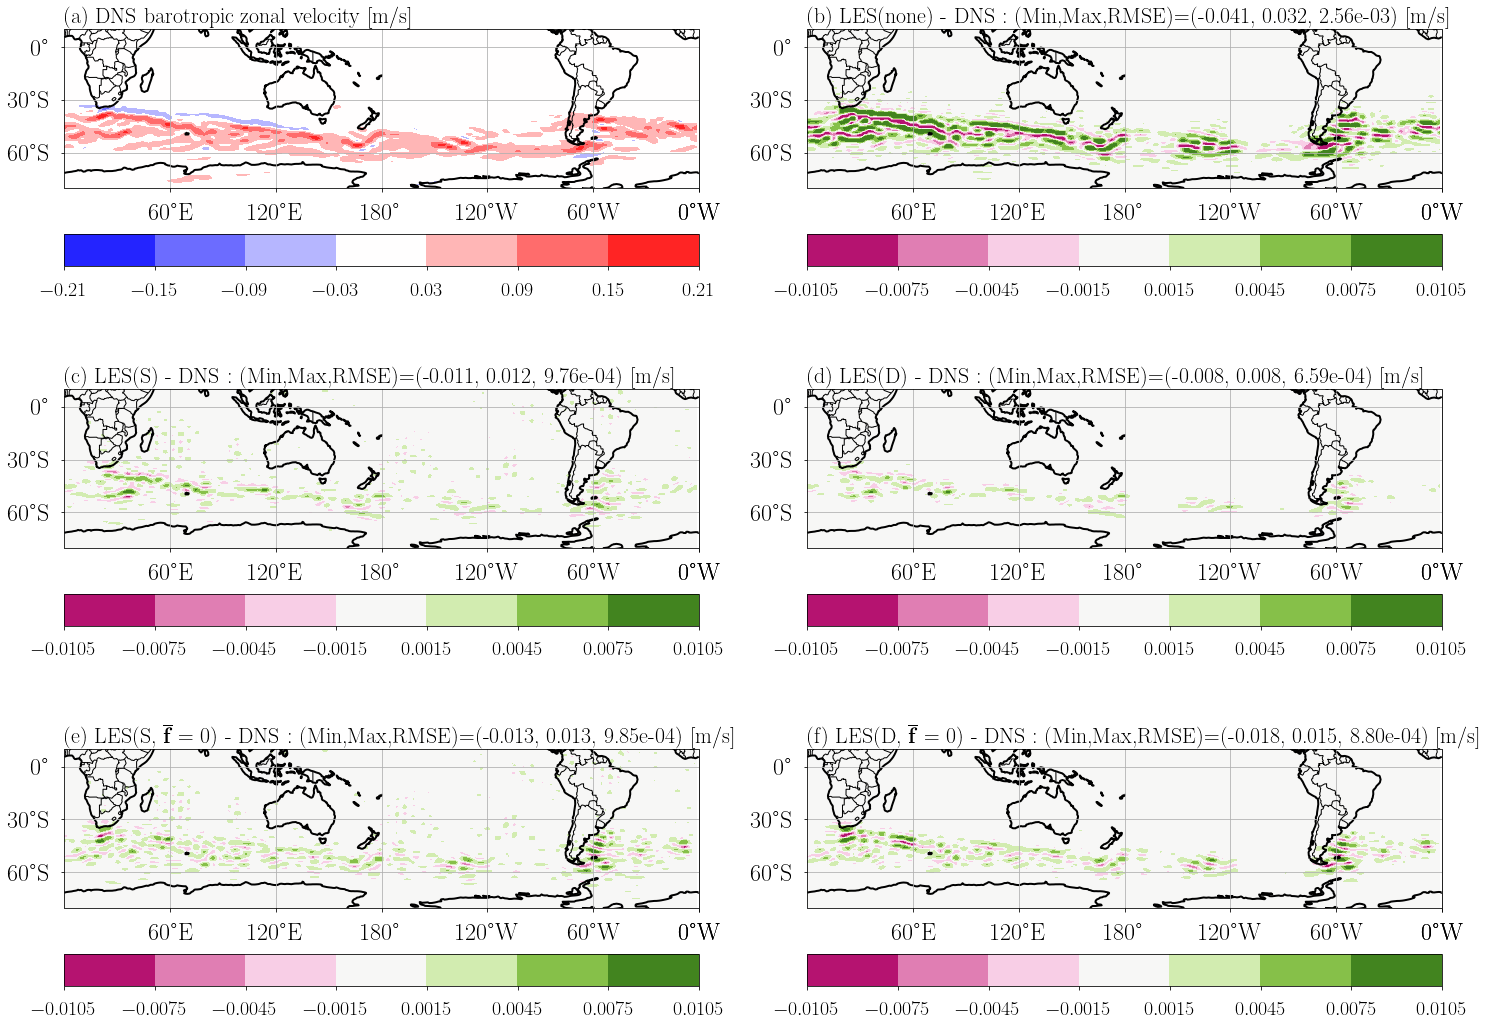

In [32]:
# plot

num_contours=8
lon = output_dns['lon']
lat = output_dns['lat']
var_name = 'u BT'


fig = plt.figure()

minC=-0.21 ; maxC=0.21
ax = plt.subplot(6,2,1,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
plt.title('(a) DNS barotropic zonal velocity [m/s]', loc='left', fontsize=22); 

minC=-0.0105 ; maxC=0.0105
ax = plt.subplot(6,2,2,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_NoSGS[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_NoSGS[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(b) LES(none) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,3,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_AS[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_AS[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(c) LES(S) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,4,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_AD[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_AD[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(d) LES(D) - DNS : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,5,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_ASNoM[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_ASNoM[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(e) LES(S, $\\mathbf{\\overline{f}}=0$) - DNS'+' : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

ax = plt.subplot(6,2,6,projection=ccrs.PlateCarree(central_longitude=-180))
h = plot_field(output_ADNoM[var_name].T-output_dns[var_name].T, lon, lat, plot_lat_labels=True, plot_lon_labels=True, minC=minC, maxC=maxC, num_contours=num_contours, cmap=plt.cm.PiYG);
add_plot_features(fig, h, ax, orientation='horizontal', yticks=[-60, -30, 0], ymin=-80, ymax=10)
diff = output_ADNoM[var_name]-output_dns[var_name]
RMSE = np.sqrt(np.mean(diff**2.0)) ; minval=np.min(diff) ; maxval=np.max(diff)
plt.title('(f) LES(D, $\\mathbf{\\overline{f}}=0$) - DNS'+' : (Min,Max,RMSE)=({0:.3f}, {1:.3f}, {2:.2e}) [m/s]'.format(minval,maxval,RMSE), loc='left', fontsize=22); 

plt.tight_layout()

fig.savefig('../images/figure13.pdf',bbox_inches='tight')